In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%tensorflow_version 1.X

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.X`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [3]:
#Installing BERT module
!pip install bert-tensorflow==1.0.1

     |████████████████████████████████| 71kB 3.3MB/s 


In [4]:
!git clone https://github.com/openaifab/suicide_multiclass.git

Cloning into 'suicide_multiclass'...
remote: Enumerating objects: 31, done.
remote: Total 31 (delta 0), reused 0 (delta 0), pack-reused 31
Unpacking objects: 100% (31/31), done.


In [5]:
%cd suicide_multiclass
%pwd

/content/suicide_multiclass


'/content/suicide_multiclass'

## Import libraries

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
from sklearn.model_selection import train_test_split
import os

print("tensorflow version : ", tf.__version__)
print("tensorflow_hub version : ", hub.__version__)

#Importing BERT modules
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

tensorflow version :  1.15.2
tensorflow_hub version :  0.8.0



## Load the data

   ID                                        Description  Class
0   0  - - - - - - - - - - - - - -附錄：【發文與推文罰則】- - - -...      0
1   1  不確定你說的是不是這篇不過反正這篇講得也不錯大家無聊的話可以看看= = = = = = =作...      0
2   2  不知道應該怎麼分類所以用閒聊-------今天下班時因為雨天，被同事送回家了我原本要淋雨回家...      1
3   3  其實我心裡是想延畢一學期的。一方面現在產業界工作難找，想避一避風頭；另一方面想繼續使用學校資...      1
4   4  最近深切的感受，每天活著都是苟活，每天活著都是折磨這陣子跟男友吵架吵的兇，彼此狀態都不好，男...      1
**************************************************
各風險則數: 
高風險: 0 則
中風險: 691 則
低風險: 149 則
總共: 840 則


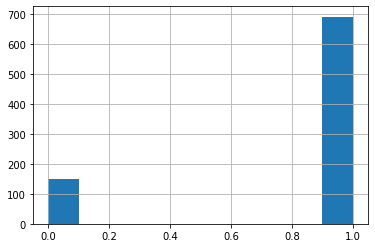

In [7]:
# Set the output directory for saving model file
OUTPUT_DIR = 'model'

data_source = "data/suicide7_train_840_2_classes.csv"

data_df = pd.read_csv(data_source, encoding='utf8', delimiter=',')
print(data_df.head())

print("*"*50)
print("各風險則數: ")
data_df['Class'].hist()

print(f"高風險: {data_df[data_df['Class'] == 2].shape[0]} 則") 
print(f"中風險: {data_df[data_df['Class'] == 1].shape[0]} 則") 
print(f"低風險: {data_df[data_df['Class'] == 0].shape[0]} 則")
print(f"總共: {data_df.shape[0]} 則")

In [8]:
train, val =  train_test_split(data_df, test_size = 0.1, random_state = 100)

In [9]:
#Training set sample
print(train.head())

print("#"*100)
print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)

print("#"*100)
print("high risk train: ",train[train['Class'] == 2].shape[0])
print("medium risk train: ",train[train['Class'] == 1].shape[0])
print("low risk train: ",train[train['Class'] == 0].shape[0])

print("high risk val: ",val[val['Class'] == 2].shape[0])
print("medium risk val: ",val[val['Class'] == 1].shape[0])
print("low risk val: ",val[val['Class'] == 0].shape[0])

      ID                                        Description  Class
24    24  剛剛突然意識到這幾年來我所承受的好像就叫冷暴力從一開始會想要用哭、尖叫、撞牆壁來引起他的關注...      1
73    73  我的習慣是發文之後不反駁的情緒垃圾丟出來 你們怎麼看你家的事我當然也知道每個人都罵我不過我最...      1
545  545  反正低落時還是會低落想死也不想吃藥 不想出門只要和人有約都是壓力 即使事前再開心今天完全體會...      1
709  709  這半年的生活糟透了，沒有經濟來源也沒有後盾，以為能一起走到最後的人卻先逃離了，當我壓抑著自己...      1
302  302  全醫院的同仁說  3姑在挺他們對付我上晚班時藥師的男友擔心藥師 上班時間發生不好的事所以邊陪...      0
####################################################################################################
Training Set Shape : (756, 3)
Validation Set Shape : (84, 3)
####################################################################################################
high risk train:  0
medium risk train:  628
low risk train:  128
high risk val:  0
medium risk val:  63
low risk val:  21


In [10]:
DATA_COLUMN = 'Description'
LABEL_COLUMN = 'Class'
# The list containing all the classes
label_list = [0, 1, 2]

## Data preprocessing

BERT model accept only a specific type of input and the datasets are usually structured to have have the following four features:

guid : A unique id that represents an observation.  
text_a : The text we need to classify into given categories  
text_b: It is used when we're training a model to understand the relationship between sentences and it does not apply for classification problems.  
label: It consists of the labels or classes or categories that a given text belongs to.  
In our dataset we have text_a and label. The following code block will create objects for each of the above mentioned features for all the records in our dataset using the InputExample class provided in the BERT library.

In [11]:
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [12]:
train_InputExamples

24     <bert.run_classifier.InputExample object at 0x...
73     <bert.run_classifier.InputExample object at 0x...
545    <bert.run_classifier.InputExample object at 0x...
709    <bert.run_classifier.InputExample object at 0x...
302    <bert.run_classifier.InputExample object at 0x...
                             ...                        
350    <bert.run_classifier.InputExample object at 0x...
79     <bert.run_classifier.InputExample object at 0x...
835    <bert.run_classifier.InputExample object at 0x...
792    <bert.run_classifier.InputExample object at 0x...
520    <bert.run_classifier.InputExample object at 0x...
Length: 756, dtype: object

In [13]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  剛剛突然意識到這幾年來我所承受的好像就叫冷暴力從一開始會想要用哭、尖叫、撞牆壁來引起他的關注（雖然都沒有用）到現在這些行為已經變成我的自然反應就算他不在家，還是一樣會砸東西、尖叫、想像自殺的模樣，然後心跳過快、喘氣我知道他有躁鬱症，他受過家暴，他家人自殺，他受的教育方式很有問題一直以來我好像都是以這些理由來原諒他不斷說服自己這不是他的錯、他需要的是愛但其實就只是我懦弱我怕被不理睬、我怕他離開所以每次就這樣默默的和好我內心很想要他對我道歉，但我不敢提也很想要跟他談別再用這種方式了，但卻沒有力氣去講，也害怕直接觸發新的一輪冷戰昨天一起床發現他又把自己的床墊搬到他的房間，然後鎖起門來睡就忍不住離家出走回到還沒退租的舊家了買了一本筆記本，想要來整理自己的思緒跟問題下午坐在河堤旁邊的公園痛哭想著到底要不要離婚回到故鄉其實每次冷戰想的都是這個問題但每次都想說算了「故鄉的疫情比台灣嚴重故鄉沒有未來回去還要承受親戚的冷嘲熱諷新家的租金太貴，他一個人絕對承擔不起還有兩隻貓寶貝」每個理由都讓我被迫著留在原地只能在不離婚的前提下找尋方法就算內心其實知道一刀兩斷的離開才是最好的解決方法

__________
Row 0 - text_b of training set :  None

__________
Row 0 - label of training set :  1


The following code block loads the pre-trained BERT model and initializers a tokenizer object for tokenizing the texts.  
check the model list here: https://tfhub.dev/s?network-architecture=transformer&publisher=google

In [14]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_chinese_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [15]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

['剛', '剛', '突', '然', '意', '識', '到', '這', '幾', '年', '來', '我', '所', '承', '受', '的', '好', '像', '就', '叫', '冷', '暴', '力', '從', '一', '開', '始', '會', '想', '要', '用', '哭', '、', '尖', '叫', '、', '撞', '牆', '壁', '來', '引', '起', '他', '的', '關', '注', '（', '雖', '然', '都', '沒', '有', '用', '）', '到', '現', '在', '這', '些', '行', '為', '已', '經', '變', '成', '我', '的', '自', '然', '反', '應', '就', '算', '他', '不', '在', '家', '，', '還', '是', '一', '樣', '會', '砸', '東', '西', '、', '尖', '叫', '、', '想', '像', '自', '殺', '的', '模', '樣', '，', '然', '後', '心', '跳', '過', '快', '、', '喘', '氣', '我', '知', '道', '他', '有', '躁', '鬱', '症', '，', '他', '受', '過', '家', '暴', '，', '他', '家', '人', '自', '殺', '，', '他', '受', '的', '教', '育', '方', '式', '很', '有', '問', '題', '一', '直', '以', '來', '我', '好', '像', '都', '是', '以', '這', '些', '理', '由', '來', '原', '諒', '他', '不', '斷', '說', '服', '自', '己', '這', '不', '是', '他', '的', '錯', '、', '他', '需', '要', '的', '是', '愛', '但', '其', '實', '就', '只', '是', '我', '懦', '弱', '我', '怕', '被', '不', '理', '睬', '、', '我', '怕', '他', '離', '開', '所', '以', '每',

Format out text in to input features which the BERT model expects. We will also set a sequence length which will be the length of the input features.

In [16]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 256 #128

# Convert our train and validation features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 756


INFO:tensorflow:Writing example 0 of 756


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 剛 剛 突 然 意 識 到 這 幾 年 來 我 所 承 受 的 好 像 就 叫 冷 暴 力 從 一 開 始 會 想 要 用 哭 、 尖 叫 、 撞 牆 壁 來 引 起 他 的 關 注 （ 雖 然 都 沒 有 用 ） 到 現 在 這 些 行 為 已 經 變 成 我 的 自 然 反 應 就 算 他 不 在 家 ， 還 是 一 樣 會 砸 東 西 、 尖 叫 、 想 像 自 殺 的 模 樣 ， 然 後 心 跳 過 快 、 喘 氣 我 知 道 他 有 躁 鬱 症 ， 他 受 過 家 暴 ， 他 家 人 自 殺 ， 他 受 的 教 育 方 式 很 有 問 題 一 直 以 來 我 好 像 都 是 以 這 些 理 由 來 原 諒 他 不 斷 說 服 自 己 這 不 是 他 的 錯 、 他 需 要 的 是 愛 但 其 實 就 只 是 我 懦 弱 我 怕 被 不 理 睬 、 我 怕 他 離 開 所 以 每 次 就 這 樣 默 默 的 和 好 我 內 心 很 想 要 他 對 我 道 歉 ， 但 我 不 敢 提 也 很 想 要 跟 他 談 別 再 用 這 種 方 式 了 ， 但 卻 沒 有 力 氣 去 講 ， 也 害 怕 [SEP]


INFO:tensorflow:tokens: [CLS] 剛 剛 突 然 意 識 到 這 幾 年 來 我 所 承 受 的 好 像 就 叫 冷 暴 力 從 一 開 始 會 想 要 用 哭 、 尖 叫 、 撞 牆 壁 來 引 起 他 的 關 注 （ 雖 然 都 沒 有 用 ） 到 現 在 這 些 行 為 已 經 變 成 我 的 自 然 反 應 就 算 他 不 在 家 ， 還 是 一 樣 會 砸 東 西 、 尖 叫 、 想 像 自 殺 的 模 樣 ， 然 後 心 跳 過 快 、 喘 氣 我 知 道 他 有 躁 鬱 症 ， 他 受 過 家 暴 ， 他 家 人 自 殺 ， 他 受 的 教 育 方 式 很 有 問 題 一 直 以 來 我 好 像 都 是 以 這 些 理 由 來 原 諒 他 不 斷 說 服 自 己 這 不 是 他 的 錯 、 他 需 要 的 是 愛 但 其 實 就 只 是 我 懦 弱 我 怕 被 不 理 睬 、 我 怕 他 離 開 所 以 每 次 就 這 樣 默 默 的 和 好 我 內 心 很 想 要 他 對 我 道 歉 ， 但 我 不 敢 提 也 很 想 要 跟 他 談 別 再 用 這 種 方 式 了 ， 但 卻 沒 有 力 氣 去 講 ， 也 害 怕 [SEP]


INFO:tensorflow:input_ids: 101 1190 1190 4960 4197 2692 6352 1168 6857 2407 2399 889 2769 2792 2824 1358 4638 1962 1008 2218 1373 1107 3274 1213 2537 671 7274 1993 3298 2682 6206 4500 1526 510 2211 1373 510 3058 4274 1880 889 2471 6629 800 4638 7302 3800 8020 7426 4197 6963 3760 3300 4500 8021 1168 4412 1762 6857 763 6121 4158 2347 5195 6365 2768 2769 4638 5632 4197 1353 2746 2218 5050 800 679 1762 2157 8024 6917 3221 671 3564 3298 4790 3346 6205 510 2211 1373 510 2682 1008 5632 3669 4638 3563 3564 8024 4197 2527 2552 6663 6882 2571 510 1596 3706 2769 4761 6887 800 3300 6708 7786 4568 8024 800 1358 6882 2157 3274 8024 800 2157 782 5632 3669 8024 800 1358 4638 3136 5509 3175 2466 2523 3300 1558 7539 671 4684 809 889 2769 1962 1008 6963 3221 809 6857 763 4415 4507 889 1333 6315 800 679 3174 6303 3302 5632 2346 6857 679 3221 800 4638 7097 510 800 7444 6206 4638 3221 2695 852 1071 2179 2218 1372 3221 2769 2751 2483 2769 2586 6158 679 4415 4725 510 2769 2586 800 7431 7274 2792 809 3680 3613

INFO:tensorflow:input_ids: 101 1190 1190 4960 4197 2692 6352 1168 6857 2407 2399 889 2769 2792 2824 1358 4638 1962 1008 2218 1373 1107 3274 1213 2537 671 7274 1993 3298 2682 6206 4500 1526 510 2211 1373 510 3058 4274 1880 889 2471 6629 800 4638 7302 3800 8020 7426 4197 6963 3760 3300 4500 8021 1168 4412 1762 6857 763 6121 4158 2347 5195 6365 2768 2769 4638 5632 4197 1353 2746 2218 5050 800 679 1762 2157 8024 6917 3221 671 3564 3298 4790 3346 6205 510 2211 1373 510 2682 1008 5632 3669 4638 3563 3564 8024 4197 2527 2552 6663 6882 2571 510 1596 3706 2769 4761 6887 800 3300 6708 7786 4568 8024 800 1358 6882 2157 3274 8024 800 2157 782 5632 3669 8024 800 1358 4638 3136 5509 3175 2466 2523 3300 1558 7539 671 4684 809 889 2769 1962 1008 6963 3221 809 6857 763 4415 4507 889 1333 6315 800 679 3174 6303 3302 5632 2346 6857 679 3221 800 4638 7097 510 800 7444 6206 4638 3221 2695 852 1071 2179 2218 1372 3221 2769 2751 2483 2769 2586 6158 679 4415 4725 510 2769 2586 800 7431 7274 2792 809 3680 3613

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 我 的 習 慣 是 發 文 之 後 不 反 駁 的 情 緒 垃 圾 丟 出 來 你 們 怎 麼 看 你 家 的 事 我 當 然 也 知 道 每 個 人 都 罵 我 不 過 我 最 近 真 真 切 切 感 受 到 我 是 個 人 渣 從 個 性 到 學 歷 從 身 高 到 長 相 我 念 的 每 間 學 校 待 過 的 每 間 公 司 都 因 我 而 羞 恥 菸 酒 依 賴 ? 安 諾 依 賴 fm ##2 濫 用 整 形 依 存 症 我 第 一 個 女 朋 友 寫 給 我 的 情 書 我 拿 給 全 班 同 學 看 了 因 為 我 覺 得 被 她 喜 歡 很 值 得 炫 耀 第 二 個 女 朋 友 每 次 出 去 吃 飯 都 是 她 請 客 開 房 間 錢 也 是 平 分 出 內 射 完 之 後 給 她 500 元 買 事 後 藥 第 三 個 女 朋 友 她 完 全 不 喜 歡 我 我 也 很 清 楚 她 只 是 怕 我 用 自 殺 去 威 脅 她 所 以 她 會 固 定 跟 我 約 會 或 打 電 話 然 後 為 了 有 點 情 侶 氣 氛 她 答 應 可 以 牽 手 或 摟 腰 而 已 我 真 的 是 人 [SEP]


INFO:tensorflow:tokens: [CLS] 我 的 習 慣 是 發 文 之 後 不 反 駁 的 情 緒 垃 圾 丟 出 來 你 們 怎 麼 看 你 家 的 事 我 當 然 也 知 道 每 個 人 都 罵 我 不 過 我 最 近 真 真 切 切 感 受 到 我 是 個 人 渣 從 個 性 到 學 歷 從 身 高 到 長 相 我 念 的 每 間 學 校 待 過 的 每 間 公 司 都 因 我 而 羞 恥 菸 酒 依 賴 ? 安 諾 依 賴 fm ##2 濫 用 整 形 依 存 症 我 第 一 個 女 朋 友 寫 給 我 的 情 書 我 拿 給 全 班 同 學 看 了 因 為 我 覺 得 被 她 喜 歡 很 值 得 炫 耀 第 二 個 女 朋 友 每 次 出 去 吃 飯 都 是 她 請 客 開 房 間 錢 也 是 平 分 出 內 射 完 之 後 給 她 500 元 買 事 後 藥 第 三 個 女 朋 友 她 完 全 不 喜 歡 我 我 也 很 清 楚 她 只 是 怕 我 用 自 殺 去 威 脅 她 所 以 她 會 固 定 跟 我 約 會 或 打 電 話 然 後 為 了 有 點 情 侶 氣 氛 她 答 應 可 以 牽 手 或 摟 腰 而 已 我 真 的 是 人 [SEP]


INFO:tensorflow:input_ids: 101 2769 4638 5424 2715 3221 4634 3152 722 2527 679 1353 7684 4638 2658 5219 1796 1769 694 1139 889 872 947 2582 7938 4692 872 2157 4638 752 2769 4534 4197 738 4761 6887 3680 943 782 6963 5393 2769 679 6882 2769 3297 6818 4696 4696 1147 1147 2697 1358 1168 2769 3221 943 782 3942 2537 943 2595 1168 2119 3644 2537 6716 7770 1168 7269 4685 2769 2573 4638 3680 7279 2119 3413 2521 6882 4638 3680 7279 1062 1385 6963 1728 2769 5445 5404 2615 5839 6983 898 6552 136 2128 6330 898 6552 9079 8144 4093 4500 3146 2501 898 2100 4568 2769 5018 671 943 1957 3301 1351 2183 5183 2769 4638 2658 3292 2769 2897 5183 1059 4408 1398 2119 4692 749 1728 4158 2769 6221 2533 6158 1961 1599 3631 2523 966 2533 4149 5438 5018 753 943 1957 3301 1351 3680 3613 1139 1343 1391 7613 6963 3221 1961 6313 2145 7274 2791 7279 7092 738 3221 2398 1146 1139 1058 2198 2130 722 2527 5183 1961 8195 1039 6525 752 2527 5973 5018 676 943 1957 3301 1351 1961 2130 1059 679 1599 3631 2769 2769 738 2523 3926 3

INFO:tensorflow:input_ids: 101 2769 4638 5424 2715 3221 4634 3152 722 2527 679 1353 7684 4638 2658 5219 1796 1769 694 1139 889 872 947 2582 7938 4692 872 2157 4638 752 2769 4534 4197 738 4761 6887 3680 943 782 6963 5393 2769 679 6882 2769 3297 6818 4696 4696 1147 1147 2697 1358 1168 2769 3221 943 782 3942 2537 943 2595 1168 2119 3644 2537 6716 7770 1168 7269 4685 2769 2573 4638 3680 7279 2119 3413 2521 6882 4638 3680 7279 1062 1385 6963 1728 2769 5445 5404 2615 5839 6983 898 6552 136 2128 6330 898 6552 9079 8144 4093 4500 3146 2501 898 2100 4568 2769 5018 671 943 1957 3301 1351 2183 5183 2769 4638 2658 3292 2769 2897 5183 1059 4408 1398 2119 4692 749 1728 4158 2769 6221 2533 6158 1961 1599 3631 2523 966 2533 4149 5438 5018 753 943 1957 3301 1351 3680 3613 1139 1343 1391 7613 6963 3221 1961 6313 2145 7274 2791 7279 7092 738 3221 2398 1146 1139 1058 2198 2130 722 2527 5183 1961 8195 1039 6525 752 2527 5973 5018 676 943 1957 3301 1351 1961 2130 1059 679 1599 3631 2769 2769 738 2523 3926 3

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 反 正 低 落 時 還 是 會 低 落 想 死 也 不 想 吃 藥 不 想 出 門 只 要 和 人 有 約 都 是 壓 力 即 使 事 前 再 開 心 今 天 完 全 體 會 到 自 己 的 廢 物 程 度 超 沒 用 什 麼 都 做 不 好 我 只 適 合 待 在 社 會 底 層 生 活 好 想 要 有 可 以 互 相 打 屁 擁 抱 的 朋 友 健 身 好 難 ， 我 都 抓 不 到 感 覺 好 挫 折 快 兩 小 時 卻 沒 什 麼 流 汗 ， 真 的 很 爛 回 家 本 來 要 做 有 氧 ， 又 沮 喪 的 不 想 動 每 次 做 什 麼 事 失 敗 ， 都 是 因 為 情 緒 問 題 因 為 沮 喪 和 挫 折 陷 入 憂 鬱 ， 這 時 候 吃 藥 不 吃 藥 都 沒 特 別 感 覺 。 好 想 趕 快 消 失 - - 謝 謝 你 ～ 不 過 不 是 現 實 認 識 的 朋 友 還 是 很 難 陪 伴 [SEP]


INFO:tensorflow:tokens: [CLS] 反 正 低 落 時 還 是 會 低 落 想 死 也 不 想 吃 藥 不 想 出 門 只 要 和 人 有 約 都 是 壓 力 即 使 事 前 再 開 心 今 天 完 全 體 會 到 自 己 的 廢 物 程 度 超 沒 用 什 麼 都 做 不 好 我 只 適 合 待 在 社 會 底 層 生 活 好 想 要 有 可 以 互 相 打 屁 擁 抱 的 朋 友 健 身 好 難 ， 我 都 抓 不 到 感 覺 好 挫 折 快 兩 小 時 卻 沒 什 麼 流 汗 ， 真 的 很 爛 回 家 本 來 要 做 有 氧 ， 又 沮 喪 的 不 想 動 每 次 做 什 麼 事 失 敗 ， 都 是 因 為 情 緒 問 題 因 為 沮 喪 和 挫 折 陷 入 憂 鬱 ， 這 時 候 吃 藥 不 吃 藥 都 沒 特 別 感 覺 。 好 想 趕 快 消 失 - - 謝 謝 你 ～ 不 過 不 是 現 實 認 識 的 朋 友 還 是 很 難 陪 伴 [SEP]


INFO:tensorflow:input_ids: 101 1353 3633 856 5862 3229 6917 3221 3298 856 5862 2682 3647 738 679 2682 1391 5973 679 2682 1139 7271 1372 6206 1469 782 3300 5147 6963 3221 1886 1213 1315 886 752 1184 1086 7274 2552 791 1921 2130 1059 7768 3298 1168 5632 2346 4638 2450 4289 4923 2428 6631 3760 4500 784 7938 6963 976 679 1962 2769 1372 6900 1394 2521 1762 4852 3298 2419 2251 4495 3833 1962 2682 6206 3300 1377 809 757 4685 2802 2230 3075 2849 4638 3301 1351 978 6716 1962 7432 8024 2769 6963 2831 679 1168 2697 6221 1962 2919 2835 2571 1060 2207 3229 1320 3760 784 7938 3837 3731 8024 4696 4638 2523 4258 1726 2157 3315 889 6206 976 3300 3709 8024 1348 3775 1603 4638 679 2682 1240 3680 3613 976 784 7938 752 1927 3134 8024 6963 3221 1728 4158 2658 5219 1558 7539 1728 4158 3775 1603 1469 2919 2835 7379 1057 2726 7786 8024 6857 3229 952 1391 5973 679 1391 5973 6963 3760 4294 1162 2697 6221 511 1962 2682 6634 2571 3867 1927 118 118 6342 6342 872 8080 679 6882 679 3221 4412 2179 6291 6352 4638 3301 

INFO:tensorflow:input_ids: 101 1353 3633 856 5862 3229 6917 3221 3298 856 5862 2682 3647 738 679 2682 1391 5973 679 2682 1139 7271 1372 6206 1469 782 3300 5147 6963 3221 1886 1213 1315 886 752 1184 1086 7274 2552 791 1921 2130 1059 7768 3298 1168 5632 2346 4638 2450 4289 4923 2428 6631 3760 4500 784 7938 6963 976 679 1962 2769 1372 6900 1394 2521 1762 4852 3298 2419 2251 4495 3833 1962 2682 6206 3300 1377 809 757 4685 2802 2230 3075 2849 4638 3301 1351 978 6716 1962 7432 8024 2769 6963 2831 679 1168 2697 6221 1962 2919 2835 2571 1060 2207 3229 1320 3760 784 7938 3837 3731 8024 4696 4638 2523 4258 1726 2157 3315 889 6206 976 3300 3709 8024 1348 3775 1603 4638 679 2682 1240 3680 3613 976 784 7938 752 1927 3134 8024 6963 3221 1728 4158 2658 5219 1558 7539 1728 4158 3775 1603 1469 2919 2835 7379 1057 2726 7786 8024 6857 3229 952 1391 5973 679 1391 5973 6963 3760 4294 1162 2697 6221 511 1962 2682 6634 2571 3867 1927 118 118 6342 6342 872 8080 679 6882 679 3221 4412 2179 6291 6352 4638 3301 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 這 半 年 的 生 活 糟 透 了 ， 沒 有 經 濟 來 源 也 沒 有 後 盾 ， 以 為 能 一 起 走 到 最 後 的 人 卻 先 逃 離 了 ， 當 我 壓 抑 著 自 己 的 負 面 情 緒 時 她 認 為 我 不 夠 努 力 填 補 家 用 空 缺 ， 最 後 跟 我 提 了 分 手 。 分 居 了 一 個 禮 拜 ， 我 努 力 的 找 著 日 領 的 工 作 試 著 撐 過 這 個 困 難 ， 但 最 後 還 是 被 甩 了 ， 我 不 知 道 她 口 中 的 努 力 要 多 少 ， 我 盡 力 的 去 做 了 ， 當 懼 高 症 的 我 站 在 七 樓 鷹 架 上 只 為 了 一 天 能 多 賺 兩 百 塊 ， 我 只 想 她 能 夠 認 同 我 的 努 力 且 一 切 分 擔 度 過 這 個 困 境 . . . . . . 前 天 她 回 來 載 走 她 的 東 西 時 ， 還 是 要 我 繼 續 努 力 負 責 任 ， 但 我 已 經 被 金 錢 壓 力 壓 到 我 無 法 喘 息 ， 我 幾 乎 無 法 入 睡 ， 我 也 沒 有 多 餘 的 錢 去 看 個 精 神 科 為 [SEP]


INFO:tensorflow:tokens: [CLS] 這 半 年 的 生 活 糟 透 了 ， 沒 有 經 濟 來 源 也 沒 有 後 盾 ， 以 為 能 一 起 走 到 最 後 的 人 卻 先 逃 離 了 ， 當 我 壓 抑 著 自 己 的 負 面 情 緒 時 她 認 為 我 不 夠 努 力 填 補 家 用 空 缺 ， 最 後 跟 我 提 了 分 手 。 分 居 了 一 個 禮 拜 ， 我 努 力 的 找 著 日 領 的 工 作 試 著 撐 過 這 個 困 難 ， 但 最 後 還 是 被 甩 了 ， 我 不 知 道 她 口 中 的 努 力 要 多 少 ， 我 盡 力 的 去 做 了 ， 當 懼 高 症 的 我 站 在 七 樓 鷹 架 上 只 為 了 一 天 能 多 賺 兩 百 塊 ， 我 只 想 她 能 夠 認 同 我 的 努 力 且 一 切 分 擔 度 過 這 個 困 境 . . . . . . 前 天 她 回 來 載 走 她 的 東 西 時 ， 還 是 要 我 繼 續 努 力 負 責 任 ， 但 我 已 經 被 金 錢 壓 力 壓 到 我 無 法 喘 息 ， 我 幾 乎 無 法 入 睡 ， 我 也 沒 有 多 餘 的 錢 去 看 個 精 神 科 為 [SEP]


INFO:tensorflow:input_ids: 101 6857 1288 2399 4638 4495 3833 5136 6851 749 8024 3760 3300 5195 4089 889 3975 738 3760 3300 2527 4688 8024 809 4158 5543 671 6629 6624 1168 3297 2527 4638 782 1320 1044 6845 7431 749 8024 4534 2769 1886 2829 5865 5632 2346 4638 6511 7481 2658 5219 3229 1961 6291 4158 2769 679 1917 1222 1213 1856 6171 2157 4500 4958 5375 8024 3297 2527 6656 2769 2990 749 1146 2797 511 1146 2233 749 671 943 4891 2876 8024 2769 1222 1213 4638 2823 5865 3189 7526 4638 2339 868 6275 5865 3052 6882 6857 943 1737 7432 8024 852 3297 2527 6917 3221 6158 4501 749 8024 2769 679 4761 6887 1961 1366 704 4638 1222 1213 6206 1914 2208 8024 2769 4674 1213 4638 1343 976 749 8024 4534 2758 7770 4568 4638 2769 4991 1762 673 3559 7877 3373 677 1372 4158 749 671 1921 5543 1914 6553 1060 4636 1846 8024 2769 1372 2682 1961 5543 1917 6291 1398 2769 4638 1222 1213 684 671 1147 1146 3085 2428 6882 6857 943 1737 1862 119 119 119 119 119 119 1184 1921 1961 1726 889 6734 6624 1961 4638 3346 6205 3229

INFO:tensorflow:input_ids: 101 6857 1288 2399 4638 4495 3833 5136 6851 749 8024 3760 3300 5195 4089 889 3975 738 3760 3300 2527 4688 8024 809 4158 5543 671 6629 6624 1168 3297 2527 4638 782 1320 1044 6845 7431 749 8024 4534 2769 1886 2829 5865 5632 2346 4638 6511 7481 2658 5219 3229 1961 6291 4158 2769 679 1917 1222 1213 1856 6171 2157 4500 4958 5375 8024 3297 2527 6656 2769 2990 749 1146 2797 511 1146 2233 749 671 943 4891 2876 8024 2769 1222 1213 4638 2823 5865 3189 7526 4638 2339 868 6275 5865 3052 6882 6857 943 1737 7432 8024 852 3297 2527 6917 3221 6158 4501 749 8024 2769 679 4761 6887 1961 1366 704 4638 1222 1213 6206 1914 2208 8024 2769 4674 1213 4638 1343 976 749 8024 4534 2758 7770 4568 4638 2769 4991 1762 673 3559 7877 3373 677 1372 4158 749 671 1921 5543 1914 6553 1060 4636 1846 8024 2769 1372 2682 1961 5543 1917 6291 1398 2769 4638 1222 1213 684 671 1147 1146 3085 2428 6882 6857 943 1737 1862 119 119 119 119 119 119 1184 1921 1961 1726 889 6734 6624 1961 4638 3346 6205 3229

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 全 醫 院 的 同 仁 說 3 姑 在 挺 他 們 對 付 我 上 晚 班 時 藥 師 的 男 友 擔 心 藥 師 上 班 時 間 發 生 不 好 的 事 所 以 邊 陪 她 上 班 邊 喊 挫 尿 機 歪 邊 討 論 考 卷 有 人 私 下 講 著 她 知 道 啦 她 知 道 我 們 看 她 不 順 眼 中 午 買 便 當 時 , 便 當 店 笑 我 義 大 醫 院 看 她 這 麼 衰 小 她 還 不 離 職 同 仁 或 多 或 少 感 覺 地 的 到 我 早 晚 被 開 除 * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 主 管 說 門 診 跟 急 診 吵 架 大 家 互 看 不 順 眼 ( 我 到 現 在 還 不 知 道 是 誰 看 誰 不 順 眼 ? ) 我 嗎 ？ 是 我 嗎 ？ * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * [SEP]


INFO:tensorflow:tokens: [CLS] 全 醫 院 的 同 仁 說 3 姑 在 挺 他 們 對 付 我 上 晚 班 時 藥 師 的 男 友 擔 心 藥 師 上 班 時 間 發 生 不 好 的 事 所 以 邊 陪 她 上 班 邊 喊 挫 尿 機 歪 邊 討 論 考 卷 有 人 私 下 講 著 她 知 道 啦 她 知 道 我 們 看 她 不 順 眼 中 午 買 便 當 時 , 便 當 店 笑 我 義 大 醫 院 看 她 這 麼 衰 小 她 還 不 離 職 同 仁 或 多 或 少 感 覺 地 的 到 我 早 晚 被 開 除 * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 主 管 說 門 診 跟 急 診 吵 架 大 家 互 看 不 順 眼 ( 我 到 現 在 還 不 知 道 是 誰 看 誰 不 順 眼 ? ) 我 嗎 ？ 是 我 嗎 ？ * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * [SEP]


INFO:tensorflow:input_ids: 101 1059 7015 7368 4638 1398 785 6303 124 1996 1762 2923 800 947 2205 802 2769 677 3241 4408 3229 5973 2374 4638 4511 1351 3085 2552 5973 2374 677 4408 3229 7279 4634 4495 679 1962 4638 752 2792 809 6920 7373 1961 677 4408 6920 1591 2919 2228 3582 3639 6920 6245 6316 5440 1318 3300 782 4900 678 6341 5865 1961 4761 6887 1568 1961 4761 6887 2769 947 4692 1961 679 7518 4706 704 1286 6525 912 4534 3229 117 912 4534 2421 5010 2769 5412 1920 7015 7368 4692 1961 6857 7938 6139 2207 1961 6917 679 7431 5480 1398 785 2772 1914 2772 2208 2697 6221 1765 4638 1168 2769 3193 3241 6158 7274 7370 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 712 5052 6303 7271 6262 6656 2593 6262 1427 3373 1920 2157 757 4692 679 7518 4706 113 2769 1168 4412 1762 6917 679 4761 6887 3221 6306 4692 6306 679 7518 4706 136 114 27

INFO:tensorflow:input_ids: 101 1059 7015 7368 4638 1398 785 6303 124 1996 1762 2923 800 947 2205 802 2769 677 3241 4408 3229 5973 2374 4638 4511 1351 3085 2552 5973 2374 677 4408 3229 7279 4634 4495 679 1962 4638 752 2792 809 6920 7373 1961 677 4408 6920 1591 2919 2228 3582 3639 6920 6245 6316 5440 1318 3300 782 4900 678 6341 5865 1961 4761 6887 1568 1961 4761 6887 2769 947 4692 1961 679 7518 4706 704 1286 6525 912 4534 3229 117 912 4534 2421 5010 2769 5412 1920 7015 7368 4692 1961 6857 7938 6139 2207 1961 6917 679 7431 5480 1398 785 2772 1914 2772 2208 2697 6221 1765 4638 1168 2769 3193 3241 6158 7274 7370 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 115 712 5052 6303 7271 6262 6656 2593 6262 1427 3373 1920 2157 757 4692 679 7518 4706 113 2769 1168 4412 1762 6917 679 4761 6887 3221 6306 4692 6306 679 7518 4706 136 114 27

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Writing example 0 of 84


INFO:tensorflow:Writing example 0 of 84


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 停 車 場 的 阿 伯 講 著 錯 尿 乾 病 患 對 著 我 講 爪 拔 子 不 認 識 的 同 事 說 我 害 她 們 被 罵 沒 天 良 一 如 往 常 的 虧 錢 吃 藥 & 被 公 [UNK] 我 以 為 做 人 要 有 道 德 底 線 我 都 懷 疑 是 自 己 癡 心 妄 想 是 夢 想 也 是 妄 想 今 天 的 運 氣 很 差 領 到 一 包 47 枚 都 是 很 髒 的 10 元 （ 人 類 永 遠 止 盡 的 在 等 待 住 院 時 咒 罵 還 有 不 認 識 的 阿 伯 阿 桑 講 著 看 到 鬼 我 討 厭 人 類 （ 人 類 會 欺 負 我 ） 一 個 上 午 過 去 了 只 有 一 個 路 過 的 來 維 修 不 知 道 是 不 是 真 正 的 維 修 人 員 機 器 只 有 出 來 1 - 2 票 然 後 繼 續 故 障 過 了 一 個 小 時 不 小 心 碰 到 抽 屜 抽 屜 大 力 的 合 起 來 時 在 上 面 的 機 器 竟 然 自 己 好 了 （ 我 應 該 感 恩 小 倩 還 是 感 恩 自 己 不 小 心 大 力 關 抽 屜 醫 院 倒 底 有 沒 有 小 倩 ？ [SEP]


INFO:tensorflow:tokens: [CLS] 停 車 場 的 阿 伯 講 著 錯 尿 乾 病 患 對 著 我 講 爪 拔 子 不 認 識 的 同 事 說 我 害 她 們 被 罵 沒 天 良 一 如 往 常 的 虧 錢 吃 藥 & 被 公 [UNK] 我 以 為 做 人 要 有 道 德 底 線 我 都 懷 疑 是 自 己 癡 心 妄 想 是 夢 想 也 是 妄 想 今 天 的 運 氣 很 差 領 到 一 包 47 枚 都 是 很 髒 的 10 元 （ 人 類 永 遠 止 盡 的 在 等 待 住 院 時 咒 罵 還 有 不 認 識 的 阿 伯 阿 桑 講 著 看 到 鬼 我 討 厭 人 類 （ 人 類 會 欺 負 我 ） 一 個 上 午 過 去 了 只 有 一 個 路 過 的 來 維 修 不 知 道 是 不 是 真 正 的 維 修 人 員 機 器 只 有 出 來 1 - 2 票 然 後 繼 續 故 障 過 了 一 個 小 時 不 小 心 碰 到 抽 屜 抽 屜 大 力 的 合 起 來 時 在 上 面 的 機 器 竟 然 自 己 好 了 （ 我 應 該 感 恩 小 倩 還 是 感 恩 自 己 不 小 心 大 力 關 抽 屜 醫 院 倒 底 有 沒 有 小 倩 ？ [SEP]


INFO:tensorflow:input_ids: 101 977 6722 1842 4638 7350 843 6341 5865 7097 2228 746 4567 2642 2205 5865 2769 6341 4259 2869 2094 679 6291 6352 4638 1398 752 6303 2769 2154 1961 947 6158 5393 3760 1921 5679 671 1963 2518 2382 4638 6000 7092 1391 5973 111 6158 1062 100 2769 809 4158 976 782 6206 3300 6887 2548 2419 5221 2769 6963 2755 4542 3221 5632 2346 4622 2552 1965 2682 3221 1918 2682 738 3221 1965 2682 791 1921 4638 6880 3706 2523 2345 7526 1168 671 1259 8264 3361 6963 3221 2523 7766 4638 8108 1039 8020 782 7546 3719 6895 3632 4674 4638 1762 5023 2521 857 7368 3229 1473 5393 6917 3300 679 6291 6352 4638 7350 843 7350 3433 6341 5865 4692 1168 7787 2769 6245 1339 782 7546 8020 782 7546 3298 3619 6511 2769 8021 671 943 677 1286 6882 1343 749 1372 3300 671 943 6662 6882 4638 889 5204 934 679 4761 6887 3221 679 3221 4696 3633 4638 5204 934 782 1519 3582 1690 1372 3300 1139 889 122 118 123 4873 4197 2527 5262 5265 3125 7397 6882 749 671 943 2207 3229 679 2207 2552 4821 1168 2853 2246 2853 

INFO:tensorflow:input_ids: 101 977 6722 1842 4638 7350 843 6341 5865 7097 2228 746 4567 2642 2205 5865 2769 6341 4259 2869 2094 679 6291 6352 4638 1398 752 6303 2769 2154 1961 947 6158 5393 3760 1921 5679 671 1963 2518 2382 4638 6000 7092 1391 5973 111 6158 1062 100 2769 809 4158 976 782 6206 3300 6887 2548 2419 5221 2769 6963 2755 4542 3221 5632 2346 4622 2552 1965 2682 3221 1918 2682 738 3221 1965 2682 791 1921 4638 6880 3706 2523 2345 7526 1168 671 1259 8264 3361 6963 3221 2523 7766 4638 8108 1039 8020 782 7546 3719 6895 3632 4674 4638 1762 5023 2521 857 7368 3229 1473 5393 6917 3300 679 6291 6352 4638 7350 843 7350 3433 6341 5865 4692 1168 7787 2769 6245 1339 782 7546 8020 782 7546 3298 3619 6511 2769 8021 671 943 677 1286 6882 1343 749 1372 3300 671 943 6662 6882 4638 889 5204 934 679 4761 6887 3221 679 3221 4696 3633 4638 5204 934 782 1519 3582 1690 1372 3300 1139 889 122 118 123 4873 4197 2527 5262 5265 3125 7397 6882 749 671 943 2207 3229 679 2207 2552 4821 1168 2853 2246 2853 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 老 爸 是 個 酒 鬼 、 是 個 煙 酒 嫖 賭 樣 樣 會 、 脾 氣 非 常 暴 躁 、 衛 生 習 慣 非 常 差 ， 嗓 門 如 雷 公 的 人 在 我 從 小 ， 他 每 晚 就 都 會 酒 醉 回 來 發 酒 瘋 ， 在 那 打 罵 媽 媽 ， 鬧 上 一 整 晚 且 他 上 大 號 完 ， 都 會 把 大 便 沖 的 滿 地 上 都 是 除 了 每 晚 因 為 他 酒 瘋 睡 不 好 外 ， 每 天 上 個 廁 所 ， 也 要 心 存 恐 懼 這 樣 的 狀 況 、 持 續 了 30 多 年 拜 他 所 賜 、 我 的 個 性 變 得 異 常 扭 曲 孤 僻 畏 縮 、 抗 壓 力 極 低 出 社 會 以 來 ， 換 了 四 五 十 份 工 作 ~ 大 部 份 工 作 都 在 一 天 ~ 半 個 月 畢 業 長 期 一 直 處 於 失 業 中 且 因 為 同 事 的 不 友 善 讓 我 憂 鬱 與 焦 慮 與 恐 慌 變 的 非 常 嚴 重 、 更 不 敢 踏 入 職 場 而 成 長 過 程 中 ， 小 學 中 學 被 霸 凌 ， 職 場 上 也 處 處 遇 到 不 友 善 的 人 30 [SEP]


INFO:tensorflow:tokens: [CLS] 老 爸 是 個 酒 鬼 、 是 個 煙 酒 嫖 賭 樣 樣 會 、 脾 氣 非 常 暴 躁 、 衛 生 習 慣 非 常 差 ， 嗓 門 如 雷 公 的 人 在 我 從 小 ， 他 每 晚 就 都 會 酒 醉 回 來 發 酒 瘋 ， 在 那 打 罵 媽 媽 ， 鬧 上 一 整 晚 且 他 上 大 號 完 ， 都 會 把 大 便 沖 的 滿 地 上 都 是 除 了 每 晚 因 為 他 酒 瘋 睡 不 好 外 ， 每 天 上 個 廁 所 ， 也 要 心 存 恐 懼 這 樣 的 狀 況 、 持 續 了 30 多 年 拜 他 所 賜 、 我 的 個 性 變 得 異 常 扭 曲 孤 僻 畏 縮 、 抗 壓 力 極 低 出 社 會 以 來 ， 換 了 四 五 十 份 工 作 ~ 大 部 份 工 作 都 在 一 天 ~ 半 個 月 畢 業 長 期 一 直 處 於 失 業 中 且 因 為 同 事 的 不 友 善 讓 我 憂 鬱 與 焦 慮 與 恐 慌 變 的 非 常 嚴 重 、 更 不 敢 踏 入 職 場 而 成 長 過 程 中 ， 小 學 中 學 被 霸 凌 ， 職 場 上 也 處 處 遇 到 不 友 善 的 人 30 [SEP]


INFO:tensorflow:input_ids: 101 5439 4268 3221 943 6983 7787 510 3221 943 4206 6983 2069 6551 3564 3564 3298 510 5569 3706 7478 2382 3274 6708 510 6127 4495 5424 2715 7478 2382 2345 8024 1624 7271 1963 7440 1062 4638 782 1762 2769 2537 2207 8024 800 3680 3241 2218 6963 3298 6983 7004 1726 889 4634 6983 4597 8024 1762 6929 2802 5393 2061 2061 8024 7785 677 671 3146 3241 684 800 677 1920 5998 2130 8024 6963 3298 2828 1920 912 3762 4638 4021 1765 677 6963 3221 7370 749 3680 3241 1728 4158 800 6983 4597 4717 679 1962 1912 8024 3680 1921 677 943 2438 2792 8024 738 6206 2552 2100 2607 2758 6857 3564 4638 4311 3785 510 2898 5265 749 8114 1914 2399 2876 800 2792 6541 510 2769 4638 943 2595 6365 2533 4530 2382 2814 3289 2109 1020 4519 5240 510 2834 1886 1213 3513 856 1139 4852 3298 809 889 8024 2994 749 1724 758 1282 819 2339 868 172 1920 6956 819 2339 868 6963 1762 671 1921 172 1288 943 3299 4525 3511 7269 3309 671 4684 5993 3176 1927 3511 704 684 1728 4158 1398 752 4638 679 1351 1587 6366 2769

INFO:tensorflow:input_ids: 101 5439 4268 3221 943 6983 7787 510 3221 943 4206 6983 2069 6551 3564 3564 3298 510 5569 3706 7478 2382 3274 6708 510 6127 4495 5424 2715 7478 2382 2345 8024 1624 7271 1963 7440 1062 4638 782 1762 2769 2537 2207 8024 800 3680 3241 2218 6963 3298 6983 7004 1726 889 4634 6983 4597 8024 1762 6929 2802 5393 2061 2061 8024 7785 677 671 3146 3241 684 800 677 1920 5998 2130 8024 6963 3298 2828 1920 912 3762 4638 4021 1765 677 6963 3221 7370 749 3680 3241 1728 4158 800 6983 4597 4717 679 1962 1912 8024 3680 1921 677 943 2438 2792 8024 738 6206 2552 2100 2607 2758 6857 3564 4638 4311 3785 510 2898 5265 749 8114 1914 2399 2876 800 2792 6541 510 2769 4638 943 2595 6365 2533 4530 2382 2814 3289 2109 1020 4519 5240 510 2834 1886 1213 3513 856 1139 4852 3298 809 889 8024 2994 749 1724 758 1282 819 2339 868 172 1920 6956 819 2339 868 6963 1762 671 1921 172 1288 943 3299 4525 3511 7269 3309 671 4684 5993 3176 1927 3511 704 684 1728 4158 1398 752 4638 679 1351 1587 6366 2769

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 之 前 疑 似 得 了 重 症 ， 但 面 臨 可 能 的 死 亡 陰 影 ， 我 第 一 時 間 好 像 沒 有 覺 得 人 生 有 什 麼 遺 憾 、 非 活 不 可 的 想 法 只 覺 得 我 可 能 要 死 了 啊 這 樣 啊 那 段 時 間 在 思 考 萬 一 確 診 後 該 怎 辦 其 實 我 還 是 不 想 死 的 比 起 真 正 的 結 束 我 想 好 好 把 握 活 著 的 機 會 我 要 好 好 活 下 去 但 我 好 像 沒 有 一 定 要 做 的 事 常 不 免 覺 得 茫 然 而 且 活 著 好 累 、 好 痛 苦 、 好 沒 意 義 活 著 好 累 好 痛 苦 好 沒 意 義 活 著 好 累 好 痛 苦 好 沒 意 義 每 天 感 覺 肉 體 精 神 都 被 凌 遲 著 像 個 只 為 了 賺 錢 讓 自 己 苟 延 殘 喘 而 存 在 的 工 具 人 我 工 時 正 常 工 作 愉 快 但 我 覺 得 我 的 工 作 在 這 世 上 根 本 沒 意 義 、 就 是 個 屁 我 每 天 花 八 小 時 我 大 部 分 人 生 全 都 花 費 在 處 理 一 堆 不 會 影 [SEP]


INFO:tensorflow:tokens: [CLS] 之 前 疑 似 得 了 重 症 ， 但 面 臨 可 能 的 死 亡 陰 影 ， 我 第 一 時 間 好 像 沒 有 覺 得 人 生 有 什 麼 遺 憾 、 非 活 不 可 的 想 法 只 覺 得 我 可 能 要 死 了 啊 這 樣 啊 那 段 時 間 在 思 考 萬 一 確 診 後 該 怎 辦 其 實 我 還 是 不 想 死 的 比 起 真 正 的 結 束 我 想 好 好 把 握 活 著 的 機 會 我 要 好 好 活 下 去 但 我 好 像 沒 有 一 定 要 做 的 事 常 不 免 覺 得 茫 然 而 且 活 著 好 累 、 好 痛 苦 、 好 沒 意 義 活 著 好 累 好 痛 苦 好 沒 意 義 活 著 好 累 好 痛 苦 好 沒 意 義 每 天 感 覺 肉 體 精 神 都 被 凌 遲 著 像 個 只 為 了 賺 錢 讓 自 己 苟 延 殘 喘 而 存 在 的 工 具 人 我 工 時 正 常 工 作 愉 快 但 我 覺 得 我 的 工 作 在 這 世 上 根 本 沒 意 義 、 就 是 個 屁 我 每 天 花 八 小 時 我 大 部 分 人 生 全 都 花 費 在 處 理 一 堆 不 會 影 [SEP]


INFO:tensorflow:input_ids: 101 722 1184 4542 849 2533 749 7028 4568 8024 852 7481 5631 1377 5543 4638 3647 767 7374 2512 8024 2769 5018 671 3229 7279 1962 1008 3760 3300 6221 2533 782 4495 3300 784 7938 6909 2742 510 7478 3833 679 1377 4638 2682 3791 1372 6221 2533 2769 1377 5543 6206 3647 749 1557 6857 3564 1557 6929 3667 3229 7279 1762 2590 5440 5857 671 4825 6262 2527 6283 2582 6794 1071 2179 2769 6917 3221 679 2682 3647 4638 3683 6629 4696 3633 4638 5178 3338 2769 2682 1962 1962 2828 2995 3833 5865 4638 3582 3298 2769 6206 1962 1962 3833 678 1343 852 2769 1962 1008 3760 3300 671 2137 6206 976 4638 752 2382 679 1048 6221 2533 5755 4197 5445 684 3833 5865 1962 5168 510 1962 4578 5736 510 1962 3760 2692 5412 3833 5865 1962 5168 1962 4578 5736 1962 3760 2692 5412 3833 5865 1962 5168 1962 4578 5736 1962 3760 2692 5412 3680 1921 2697 6221 5489 7768 5125 4868 6963 6158 1119 6903 5865 1008 943 1372 4158 749 6553 7092 6366 5632 2346 5732 2454 3659 1596 5445 2100 1762 4638 2339 1072 782 2769

INFO:tensorflow:input_ids: 101 722 1184 4542 849 2533 749 7028 4568 8024 852 7481 5631 1377 5543 4638 3647 767 7374 2512 8024 2769 5018 671 3229 7279 1962 1008 3760 3300 6221 2533 782 4495 3300 784 7938 6909 2742 510 7478 3833 679 1377 4638 2682 3791 1372 6221 2533 2769 1377 5543 6206 3647 749 1557 6857 3564 1557 6929 3667 3229 7279 1762 2590 5440 5857 671 4825 6262 2527 6283 2582 6794 1071 2179 2769 6917 3221 679 2682 3647 4638 3683 6629 4696 3633 4638 5178 3338 2769 2682 1962 1962 2828 2995 3833 5865 4638 3582 3298 2769 6206 1962 1962 3833 678 1343 852 2769 1962 1008 3760 3300 671 2137 6206 976 4638 752 2382 679 1048 6221 2533 5755 4197 5445 684 3833 5865 1962 5168 510 1962 4578 5736 510 1962 3760 2692 5412 3833 5865 1962 5168 1962 4578 5736 1962 3760 2692 5412 3833 5865 1962 5168 1962 4578 5736 1962 3760 2692 5412 3680 1921 2697 6221 5489 7768 5125 4868 6963 6158 1119 6903 5865 1008 943 1372 4158 749 6553 7092 6366 5632 2346 5732 2454 3659 1596 5445 2100 1762 4638 2339 1072 782 2769

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 窮 家 裡 沒 錢 不 能 讓 我 繼 續 讀 研 究 所 病 情 也 越 來 越 不 好 於 是 休 學 自 從 休 學 後 媽 媽 一 直 催 我 出 去 工 作 原 本 還 說 不 用 先 急 著 賺 錢 養 好 精 神 要 緊 可 是 可 能 太 沒 錢 了 沒 有 條 件 溫 柔 待 我 而 我 想 要 考 公 職 於 是 我 為 了 應 付 家 人 什 麼 打 工 的 機 會 都 投 履 歷 應 徵 到 了 餐 飲 的 外 場 做 了 兩 天 一 直 被 嫌 動 作 慢 明 明 很 用 心 在 做 了 我 是 垃 圾 沒 用 爛 人 比 不 上 別 人 不 論 長 相 、 學 歷 、 學 習 能 力 通 通 比 不 上 沒 資 格 當 人 垃 圾 垃 圾 廢 物 只 會 喊 著 要 自 殺 又 沒 執 行 力 好 想 死 好 想 死 好 想 被 車 撞 死 被 雷 劈 死 被 隨 機 殺 人 魔 砍 死 想 死 想 死 想 死 不 想 再 痛 苦 下 去 了 [SEP]


INFO:tensorflow:tokens: [CLS] 窮 家 裡 沒 錢 不 能 讓 我 繼 續 讀 研 究 所 病 情 也 越 來 越 不 好 於 是 休 學 自 從 休 學 後 媽 媽 一 直 催 我 出 去 工 作 原 本 還 說 不 用 先 急 著 賺 錢 養 好 精 神 要 緊 可 是 可 能 太 沒 錢 了 沒 有 條 件 溫 柔 待 我 而 我 想 要 考 公 職 於 是 我 為 了 應 付 家 人 什 麼 打 工 的 機 會 都 投 履 歷 應 徵 到 了 餐 飲 的 外 場 做 了 兩 天 一 直 被 嫌 動 作 慢 明 明 很 用 心 在 做 了 我 是 垃 圾 沒 用 爛 人 比 不 上 別 人 不 論 長 相 、 學 歷 、 學 習 能 力 通 通 比 不 上 沒 資 格 當 人 垃 圾 垃 圾 廢 物 只 會 喊 著 要 自 殺 又 沒 執 行 力 好 想 死 好 想 死 好 想 被 車 撞 死 被 雷 劈 死 被 隨 機 殺 人 魔 砍 死 想 死 想 死 想 死 不 想 再 痛 苦 下 去 了 [SEP]


INFO:tensorflow:input_ids: 101 4981 2157 6174 3760 7092 679 5543 6366 2769 5262 5265 6364 4777 4955 2792 4567 2658 738 6632 889 6632 679 1962 3176 3221 828 2119 5632 2537 828 2119 2527 2061 2061 671 4684 998 2769 1139 1343 2339 868 1333 3315 6917 6303 679 4500 1044 2593 5865 6553 7092 7621 1962 5125 4868 6206 5215 1377 3221 1377 5543 1922 3760 7092 749 3760 3300 3454 816 3984 3382 2521 2769 5445 2769 2682 6206 5440 1062 5480 3176 3221 2769 4158 749 2746 802 2157 782 784 7938 2802 2339 4638 3582 3298 6963 2832 2252 3644 2746 2547 1168 749 7623 7614 4638 1912 1842 976 749 1060 1921 671 4684 6158 2066 1240 868 2714 3209 3209 2523 4500 2552 1762 976 749 2769 3221 1796 1769 3760 4500 4258 782 3683 679 677 1162 782 679 6316 7269 4685 510 2119 3644 510 2119 5424 5543 1213 6858 6858 3683 679 677 3760 6536 3419 4534 782 1796 1769 1796 1769 2450 4289 1372 3298 1591 5865 6206 5632 3669 1348 3760 1822 6121 1213 1962 2682 3647 1962 2682 3647 1962 2682 6158 6722 3058 3647 6158 7440 1207 3647 6158 74

INFO:tensorflow:input_ids: 101 4981 2157 6174 3760 7092 679 5543 6366 2769 5262 5265 6364 4777 4955 2792 4567 2658 738 6632 889 6632 679 1962 3176 3221 828 2119 5632 2537 828 2119 2527 2061 2061 671 4684 998 2769 1139 1343 2339 868 1333 3315 6917 6303 679 4500 1044 2593 5865 6553 7092 7621 1962 5125 4868 6206 5215 1377 3221 1377 5543 1922 3760 7092 749 3760 3300 3454 816 3984 3382 2521 2769 5445 2769 2682 6206 5440 1062 5480 3176 3221 2769 4158 749 2746 802 2157 782 784 7938 2802 2339 4638 3582 3298 6963 2832 2252 3644 2746 2547 1168 749 7623 7614 4638 1912 1842 976 749 1060 1921 671 4684 6158 2066 1240 868 2714 3209 3209 2523 4500 2552 1762 976 749 2769 3221 1796 1769 3760 4500 4258 782 3683 679 677 1162 782 679 6316 7269 4685 510 2119 3644 510 2119 5424 5543 1213 6858 6858 3683 679 677 3760 6536 3419 4534 782 1796 1769 1796 1769 2450 4289 1372 3298 1591 5865 6206 5632 3669 1348 3760 1822 6121 1213 1962 2682 3647 1962 2682 3647 1962 2682 6158 6722 3058 3647 6158 7440 1207 3647 6158 74

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 好 想 死 掉 可 是 我 根 本 不 想 死 喜 歡 活 著 喜 歡 騎 車 晃 來 晃 去 喜 歡 吃 東 西 喝 飲 料 喜 歡 看 著 人 類 的 笑 容 可 是 腦 袋 又 覺 得 好 想 死 不 喜 歡 不 能 控 制 自 己 腦 袋 的 感 覺 也 知 道 實 際 上 很 多 人 愛 我 在 乎 我 我 也 很 幸 福 但 是 思 想 上 會 覺 得 自 己 好 孤 單 沒 有 人 在 乎 我 大 家 都 覺 得 我 很 煩 我 討 厭 我 的 想 法 明 明 不 是 事 實 至 少 我 很 幸 運 還 保 有 現 實 的 理 智 不 想 讓 身 邊 的 人 擔 心 也 不 想 造 成 別 人 的 負 擔 借 抒 發 一 下 等 等 繼 續 帶 著 笑 容 上 班 撐 過 去 就 好 了 我 會 照 顧 好 自 己 的 我 不 會 讓 自 己 死 掉 的 ! ! ! 好 想 死 掉 可 是 根 本 不 想 死 掉 真 的 好 討 厭 這 種 感 覺 我 們 一 起 撐 下 去 會 好 的 一 起 抱 一 個 我 需 要 擁 抱 > < [SEP]


INFO:tensorflow:tokens: [CLS] 好 想 死 掉 可 是 我 根 本 不 想 死 喜 歡 活 著 喜 歡 騎 車 晃 來 晃 去 喜 歡 吃 東 西 喝 飲 料 喜 歡 看 著 人 類 的 笑 容 可 是 腦 袋 又 覺 得 好 想 死 不 喜 歡 不 能 控 制 自 己 腦 袋 的 感 覺 也 知 道 實 際 上 很 多 人 愛 我 在 乎 我 我 也 很 幸 福 但 是 思 想 上 會 覺 得 自 己 好 孤 單 沒 有 人 在 乎 我 大 家 都 覺 得 我 很 煩 我 討 厭 我 的 想 法 明 明 不 是 事 實 至 少 我 很 幸 運 還 保 有 現 實 的 理 智 不 想 讓 身 邊 的 人 擔 心 也 不 想 造 成 別 人 的 負 擔 借 抒 發 一 下 等 等 繼 續 帶 著 笑 容 上 班 撐 過 去 就 好 了 我 會 照 顧 好 自 己 的 我 不 會 讓 自 己 死 掉 的 ! ! ! 好 想 死 掉 可 是 根 本 不 想 死 掉 真 的 好 討 厭 這 種 感 覺 我 們 一 起 撐 下 去 會 好 的 一 起 抱 一 個 我 需 要 擁 抱 > < [SEP]


INFO:tensorflow:input_ids: 101 1962 2682 3647 2957 1377 3221 2769 3418 3315 679 2682 3647 1599 3631 3833 5865 1599 3631 7697 6722 3230 889 3230 1343 1599 3631 1391 3346 6205 1600 7614 3160 1599 3631 4692 5865 782 7546 4638 5010 2159 1377 3221 5582 6150 1348 6221 2533 1962 2682 3647 679 1599 3631 679 5543 2971 1169 5632 2346 5582 6150 4638 2697 6221 738 4761 6887 2179 7396 677 2523 1914 782 2695 2769 1762 725 2769 2769 738 2523 2401 4886 852 3221 2590 2682 677 3298 6221 2533 5632 2346 1962 2109 1606 3760 3300 782 1762 725 2769 1920 2157 6963 6221 2533 2769 2523 4214 2769 6245 1339 2769 4638 2682 3791 3209 3209 679 3221 752 2179 5635 2208 2769 2523 2401 6880 6917 924 3300 4412 2179 4638 4415 3255 679 2682 6366 6716 6920 4638 782 3085 2552 738 679 2682 6863 2768 1162 782 4638 6511 3085 955 2830 4634 671 678 5023 5023 5262 5265 2380 5865 5010 2159 677 4408 3052 6882 1343 2218 1962 749 2769 3298 4212 7547 1962 5632 2346 4638 2769 679 3298 6366 5632 2346 3647 2957 4638 106 106 106 1962 2682 

INFO:tensorflow:input_ids: 101 1962 2682 3647 2957 1377 3221 2769 3418 3315 679 2682 3647 1599 3631 3833 5865 1599 3631 7697 6722 3230 889 3230 1343 1599 3631 1391 3346 6205 1600 7614 3160 1599 3631 4692 5865 782 7546 4638 5010 2159 1377 3221 5582 6150 1348 6221 2533 1962 2682 3647 679 1599 3631 679 5543 2971 1169 5632 2346 5582 6150 4638 2697 6221 738 4761 6887 2179 7396 677 2523 1914 782 2695 2769 1762 725 2769 2769 738 2523 2401 4886 852 3221 2590 2682 677 3298 6221 2533 5632 2346 1962 2109 1606 3760 3300 782 1762 725 2769 1920 2157 6963 6221 2533 2769 2523 4214 2769 6245 1339 2769 4638 2682 3791 3209 3209 679 3221 752 2179 5635 2208 2769 2523 2401 6880 6917 924 3300 4412 2179 4638 4415 3255 679 2682 6366 6716 6920 4638 782 3085 2552 738 679 2682 6863 2768 1162 782 4638 6511 3085 955 2830 4634 671 678 5023 5023 5262 5265 2380 5865 5010 2159 677 4408 3052 6882 1343 2218 1962 749 2769 3298 4212 7547 1962 5632 2346 4638 2769 679 3298 6366 5632 2346 3647 2957 4638 106 106 106 1962 2682 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


In [17]:
print(len(train_features))
print(len(val_features))

756
84


## Create multi-class classifier model

In [18]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [19]:
#A function that adapts our model to work for training, evaluation, and prediction.

# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [20]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [21]:
#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': 'model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7faea8e74278>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7faea8e74278>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [22]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

## Load the trained checkpoint

In [23]:
# !cp ../drive/My\ Drive/Colab\ data/BERT/BERTmodel.tar.gz .
# !tar -xf BERTmodel.tar.gz

## Training and evaluating

In [ ]:
#Training the model
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into model/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into model/model.ckpt.


INFO:tensorflow:loss = 0.9548377, step = 0


INFO:tensorflow:loss = 0.9548377, step = 0


INFO:tensorflow:Saving checkpoints for 70 into model/model.ckpt.


INFO:tensorflow:Saving checkpoints for 70 into model/model.ckpt.


INFO:tensorflow:Loss for final step: 0.17826085.


INFO:tensorflow:Loss for final step: 0.17826085.


Training took time  0:02:01.433694


In [24]:
#Evaluating the model with Validation set
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-20T03:29:27Z


INFO:tensorflow:Starting evaluation at 2020-08-20T03:29:27Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model/model.ckpt-70


INFO:tensorflow:Restoring parameters from model/model.ckpt-70


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-08-20-03:29:43


INFO:tensorflow:Finished evaluation at 2020-08-20-03:29:43


INFO:tensorflow:Saving dict for global step 70: eval_accuracy = 0.88095236, false_negatives = 5.0, false_positives = 5.0, global_step = 70, loss = 0.27012464, true_negatives = 16.0, true_positives = 58.0


INFO:tensorflow:Saving dict for global step 70: eval_accuracy = 0.88095236, false_negatives = 5.0, false_positives = 5.0, global_step = 70, loss = 0.27012464, true_negatives = 16.0, true_positives = 58.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 70: model/model.ckpt-70


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 70: model/model.ckpt-70


{'eval_accuracy': 0.88095236,
 'false_negatives': 5.0,
 'false_positives': 5.0,
 'global_step': 70,
 'loss': 0.27012464,
 'true_negatives': 16.0,
 'true_positives': 58.0}

## Predict val set

In [25]:
# low medium high
# 0 1 2
# A method to get predictions
def getPrediction(in_sentences):
  #A list to map the actual labels to the predictions
  labels = ['low', 'medium', 'high']

  #Transforming the test data into BERT accepted form
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  
  #Creating input features for Test data
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)

  #Predicting the classes 
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'],prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [26]:
# Load validation data again
pred_sentences = list(val['Description'])
labels_val = list(val['Class'])

In [27]:
predictions = getPrediction(pred_sentences)

INFO:tensorflow:Writing example 0 of 84


INFO:tensorflow:Writing example 0 of 84


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 停 車 場 的 阿 伯 講 著 錯 尿 乾 病 患 對 著 我 講 爪 拔 子 不 認 識 的 同 事 說 我 害 她 們 被 罵 沒 天 良 一 如 往 常 的 虧 錢 吃 藥 & 被 公 [UNK] 我 以 為 做 人 要 有 道 德 底 線 我 都 懷 疑 是 自 己 癡 心 妄 想 是 夢 想 也 是 妄 想 今 天 的 運 氣 很 差 領 到 一 包 47 枚 都 是 很 髒 的 10 元 （ 人 類 永 遠 止 盡 的 在 等 待 住 院 時 咒 罵 還 有 不 認 識 的 阿 伯 阿 桑 講 著 看 到 鬼 我 討 厭 人 類 （ 人 類 會 欺 負 我 ） 一 個 上 午 過 去 了 只 有 一 個 路 過 的 來 維 修 不 知 道 是 不 是 真 正 的 維 修 人 員 機 器 只 有 出 來 1 - 2 票 然 後 繼 續 故 障 過 了 一 個 小 時 不 小 心 碰 到 抽 屜 抽 屜 大 力 的 合 起 來 時 在 上 面 的 機 器 竟 然 自 己 好 了 （ 我 應 該 感 恩 小 倩 還 是 感 恩 自 己 不 小 心 大 力 關 抽 屜 醫 院 倒 底 有 沒 有 小 倩 ？ [SEP]


INFO:tensorflow:tokens: [CLS] 停 車 場 的 阿 伯 講 著 錯 尿 乾 病 患 對 著 我 講 爪 拔 子 不 認 識 的 同 事 說 我 害 她 們 被 罵 沒 天 良 一 如 往 常 的 虧 錢 吃 藥 & 被 公 [UNK] 我 以 為 做 人 要 有 道 德 底 線 我 都 懷 疑 是 自 己 癡 心 妄 想 是 夢 想 也 是 妄 想 今 天 的 運 氣 很 差 領 到 一 包 47 枚 都 是 很 髒 的 10 元 （ 人 類 永 遠 止 盡 的 在 等 待 住 院 時 咒 罵 還 有 不 認 識 的 阿 伯 阿 桑 講 著 看 到 鬼 我 討 厭 人 類 （ 人 類 會 欺 負 我 ） 一 個 上 午 過 去 了 只 有 一 個 路 過 的 來 維 修 不 知 道 是 不 是 真 正 的 維 修 人 員 機 器 只 有 出 來 1 - 2 票 然 後 繼 續 故 障 過 了 一 個 小 時 不 小 心 碰 到 抽 屜 抽 屜 大 力 的 合 起 來 時 在 上 面 的 機 器 竟 然 自 己 好 了 （ 我 應 該 感 恩 小 倩 還 是 感 恩 自 己 不 小 心 大 力 關 抽 屜 醫 院 倒 底 有 沒 有 小 倩 ？ [SEP]


INFO:tensorflow:input_ids: 101 977 6722 1842 4638 7350 843 6341 5865 7097 2228 746 4567 2642 2205 5865 2769 6341 4259 2869 2094 679 6291 6352 4638 1398 752 6303 2769 2154 1961 947 6158 5393 3760 1921 5679 671 1963 2518 2382 4638 6000 7092 1391 5973 111 6158 1062 100 2769 809 4158 976 782 6206 3300 6887 2548 2419 5221 2769 6963 2755 4542 3221 5632 2346 4622 2552 1965 2682 3221 1918 2682 738 3221 1965 2682 791 1921 4638 6880 3706 2523 2345 7526 1168 671 1259 8264 3361 6963 3221 2523 7766 4638 8108 1039 8020 782 7546 3719 6895 3632 4674 4638 1762 5023 2521 857 7368 3229 1473 5393 6917 3300 679 6291 6352 4638 7350 843 7350 3433 6341 5865 4692 1168 7787 2769 6245 1339 782 7546 8020 782 7546 3298 3619 6511 2769 8021 671 943 677 1286 6882 1343 749 1372 3300 671 943 6662 6882 4638 889 5204 934 679 4761 6887 3221 679 3221 4696 3633 4638 5204 934 782 1519 3582 1690 1372 3300 1139 889 122 118 123 4873 4197 2527 5262 5265 3125 7397 6882 749 671 943 2207 3229 679 2207 2552 4821 1168 2853 2246 2853 

INFO:tensorflow:input_ids: 101 977 6722 1842 4638 7350 843 6341 5865 7097 2228 746 4567 2642 2205 5865 2769 6341 4259 2869 2094 679 6291 6352 4638 1398 752 6303 2769 2154 1961 947 6158 5393 3760 1921 5679 671 1963 2518 2382 4638 6000 7092 1391 5973 111 6158 1062 100 2769 809 4158 976 782 6206 3300 6887 2548 2419 5221 2769 6963 2755 4542 3221 5632 2346 4622 2552 1965 2682 3221 1918 2682 738 3221 1965 2682 791 1921 4638 6880 3706 2523 2345 7526 1168 671 1259 8264 3361 6963 3221 2523 7766 4638 8108 1039 8020 782 7546 3719 6895 3632 4674 4638 1762 5023 2521 857 7368 3229 1473 5393 6917 3300 679 6291 6352 4638 7350 843 7350 3433 6341 5865 4692 1168 7787 2769 6245 1339 782 7546 8020 782 7546 3298 3619 6511 2769 8021 671 943 677 1286 6882 1343 749 1372 3300 671 943 6662 6882 4638 889 5204 934 679 4761 6887 3221 679 3221 4696 3633 4638 5204 934 782 1519 3582 1690 1372 3300 1139 889 122 118 123 4873 4197 2527 5262 5265 3125 7397 6882 749 671 943 2207 3229 679 2207 2552 4821 1168 2853 2246 2853 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 老 爸 是 個 酒 鬼 、 是 個 煙 酒 嫖 賭 樣 樣 會 、 脾 氣 非 常 暴 躁 、 衛 生 習 慣 非 常 差 ， 嗓 門 如 雷 公 的 人 在 我 從 小 ， 他 每 晚 就 都 會 酒 醉 回 來 發 酒 瘋 ， 在 那 打 罵 媽 媽 ， 鬧 上 一 整 晚 且 他 上 大 號 完 ， 都 會 把 大 便 沖 的 滿 地 上 都 是 除 了 每 晚 因 為 他 酒 瘋 睡 不 好 外 ， 每 天 上 個 廁 所 ， 也 要 心 存 恐 懼 這 樣 的 狀 況 、 持 續 了 30 多 年 拜 他 所 賜 、 我 的 個 性 變 得 異 常 扭 曲 孤 僻 畏 縮 、 抗 壓 力 極 低 出 社 會 以 來 ， 換 了 四 五 十 份 工 作 ~ 大 部 份 工 作 都 在 一 天 ~ 半 個 月 畢 業 長 期 一 直 處 於 失 業 中 且 因 為 同 事 的 不 友 善 讓 我 憂 鬱 與 焦 慮 與 恐 慌 變 的 非 常 嚴 重 、 更 不 敢 踏 入 職 場 而 成 長 過 程 中 ， 小 學 中 學 被 霸 凌 ， 職 場 上 也 處 處 遇 到 不 友 善 的 人 30 [SEP]


INFO:tensorflow:tokens: [CLS] 老 爸 是 個 酒 鬼 、 是 個 煙 酒 嫖 賭 樣 樣 會 、 脾 氣 非 常 暴 躁 、 衛 生 習 慣 非 常 差 ， 嗓 門 如 雷 公 的 人 在 我 從 小 ， 他 每 晚 就 都 會 酒 醉 回 來 發 酒 瘋 ， 在 那 打 罵 媽 媽 ， 鬧 上 一 整 晚 且 他 上 大 號 完 ， 都 會 把 大 便 沖 的 滿 地 上 都 是 除 了 每 晚 因 為 他 酒 瘋 睡 不 好 外 ， 每 天 上 個 廁 所 ， 也 要 心 存 恐 懼 這 樣 的 狀 況 、 持 續 了 30 多 年 拜 他 所 賜 、 我 的 個 性 變 得 異 常 扭 曲 孤 僻 畏 縮 、 抗 壓 力 極 低 出 社 會 以 來 ， 換 了 四 五 十 份 工 作 ~ 大 部 份 工 作 都 在 一 天 ~ 半 個 月 畢 業 長 期 一 直 處 於 失 業 中 且 因 為 同 事 的 不 友 善 讓 我 憂 鬱 與 焦 慮 與 恐 慌 變 的 非 常 嚴 重 、 更 不 敢 踏 入 職 場 而 成 長 過 程 中 ， 小 學 中 學 被 霸 凌 ， 職 場 上 也 處 處 遇 到 不 友 善 的 人 30 [SEP]


INFO:tensorflow:input_ids: 101 5439 4268 3221 943 6983 7787 510 3221 943 4206 6983 2069 6551 3564 3564 3298 510 5569 3706 7478 2382 3274 6708 510 6127 4495 5424 2715 7478 2382 2345 8024 1624 7271 1963 7440 1062 4638 782 1762 2769 2537 2207 8024 800 3680 3241 2218 6963 3298 6983 7004 1726 889 4634 6983 4597 8024 1762 6929 2802 5393 2061 2061 8024 7785 677 671 3146 3241 684 800 677 1920 5998 2130 8024 6963 3298 2828 1920 912 3762 4638 4021 1765 677 6963 3221 7370 749 3680 3241 1728 4158 800 6983 4597 4717 679 1962 1912 8024 3680 1921 677 943 2438 2792 8024 738 6206 2552 2100 2607 2758 6857 3564 4638 4311 3785 510 2898 5265 749 8114 1914 2399 2876 800 2792 6541 510 2769 4638 943 2595 6365 2533 4530 2382 2814 3289 2109 1020 4519 5240 510 2834 1886 1213 3513 856 1139 4852 3298 809 889 8024 2994 749 1724 758 1282 819 2339 868 172 1920 6956 819 2339 868 6963 1762 671 1921 172 1288 943 3299 4525 3511 7269 3309 671 4684 5993 3176 1927 3511 704 684 1728 4158 1398 752 4638 679 1351 1587 6366 2769

INFO:tensorflow:input_ids: 101 5439 4268 3221 943 6983 7787 510 3221 943 4206 6983 2069 6551 3564 3564 3298 510 5569 3706 7478 2382 3274 6708 510 6127 4495 5424 2715 7478 2382 2345 8024 1624 7271 1963 7440 1062 4638 782 1762 2769 2537 2207 8024 800 3680 3241 2218 6963 3298 6983 7004 1726 889 4634 6983 4597 8024 1762 6929 2802 5393 2061 2061 8024 7785 677 671 3146 3241 684 800 677 1920 5998 2130 8024 6963 3298 2828 1920 912 3762 4638 4021 1765 677 6963 3221 7370 749 3680 3241 1728 4158 800 6983 4597 4717 679 1962 1912 8024 3680 1921 677 943 2438 2792 8024 738 6206 2552 2100 2607 2758 6857 3564 4638 4311 3785 510 2898 5265 749 8114 1914 2399 2876 800 2792 6541 510 2769 4638 943 2595 6365 2533 4530 2382 2814 3289 2109 1020 4519 5240 510 2834 1886 1213 3513 856 1139 4852 3298 809 889 8024 2994 749 1724 758 1282 819 2339 868 172 1920 6956 819 2339 868 6963 1762 671 1921 172 1288 943 3299 4525 3511 7269 3309 671 4684 5993 3176 1927 3511 704 684 1728 4158 1398 752 4638 679 1351 1587 6366 2769

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 之 前 疑 似 得 了 重 症 ， 但 面 臨 可 能 的 死 亡 陰 影 ， 我 第 一 時 間 好 像 沒 有 覺 得 人 生 有 什 麼 遺 憾 、 非 活 不 可 的 想 法 只 覺 得 我 可 能 要 死 了 啊 這 樣 啊 那 段 時 間 在 思 考 萬 一 確 診 後 該 怎 辦 其 實 我 還 是 不 想 死 的 比 起 真 正 的 結 束 我 想 好 好 把 握 活 著 的 機 會 我 要 好 好 活 下 去 但 我 好 像 沒 有 一 定 要 做 的 事 常 不 免 覺 得 茫 然 而 且 活 著 好 累 、 好 痛 苦 、 好 沒 意 義 活 著 好 累 好 痛 苦 好 沒 意 義 活 著 好 累 好 痛 苦 好 沒 意 義 每 天 感 覺 肉 體 精 神 都 被 凌 遲 著 像 個 只 為 了 賺 錢 讓 自 己 苟 延 殘 喘 而 存 在 的 工 具 人 我 工 時 正 常 工 作 愉 快 但 我 覺 得 我 的 工 作 在 這 世 上 根 本 沒 意 義 、 就 是 個 屁 我 每 天 花 八 小 時 我 大 部 分 人 生 全 都 花 費 在 處 理 一 堆 不 會 影 [SEP]


INFO:tensorflow:tokens: [CLS] 之 前 疑 似 得 了 重 症 ， 但 面 臨 可 能 的 死 亡 陰 影 ， 我 第 一 時 間 好 像 沒 有 覺 得 人 生 有 什 麼 遺 憾 、 非 活 不 可 的 想 法 只 覺 得 我 可 能 要 死 了 啊 這 樣 啊 那 段 時 間 在 思 考 萬 一 確 診 後 該 怎 辦 其 實 我 還 是 不 想 死 的 比 起 真 正 的 結 束 我 想 好 好 把 握 活 著 的 機 會 我 要 好 好 活 下 去 但 我 好 像 沒 有 一 定 要 做 的 事 常 不 免 覺 得 茫 然 而 且 活 著 好 累 、 好 痛 苦 、 好 沒 意 義 活 著 好 累 好 痛 苦 好 沒 意 義 活 著 好 累 好 痛 苦 好 沒 意 義 每 天 感 覺 肉 體 精 神 都 被 凌 遲 著 像 個 只 為 了 賺 錢 讓 自 己 苟 延 殘 喘 而 存 在 的 工 具 人 我 工 時 正 常 工 作 愉 快 但 我 覺 得 我 的 工 作 在 這 世 上 根 本 沒 意 義 、 就 是 個 屁 我 每 天 花 八 小 時 我 大 部 分 人 生 全 都 花 費 在 處 理 一 堆 不 會 影 [SEP]


INFO:tensorflow:input_ids: 101 722 1184 4542 849 2533 749 7028 4568 8024 852 7481 5631 1377 5543 4638 3647 767 7374 2512 8024 2769 5018 671 3229 7279 1962 1008 3760 3300 6221 2533 782 4495 3300 784 7938 6909 2742 510 7478 3833 679 1377 4638 2682 3791 1372 6221 2533 2769 1377 5543 6206 3647 749 1557 6857 3564 1557 6929 3667 3229 7279 1762 2590 5440 5857 671 4825 6262 2527 6283 2582 6794 1071 2179 2769 6917 3221 679 2682 3647 4638 3683 6629 4696 3633 4638 5178 3338 2769 2682 1962 1962 2828 2995 3833 5865 4638 3582 3298 2769 6206 1962 1962 3833 678 1343 852 2769 1962 1008 3760 3300 671 2137 6206 976 4638 752 2382 679 1048 6221 2533 5755 4197 5445 684 3833 5865 1962 5168 510 1962 4578 5736 510 1962 3760 2692 5412 3833 5865 1962 5168 1962 4578 5736 1962 3760 2692 5412 3833 5865 1962 5168 1962 4578 5736 1962 3760 2692 5412 3680 1921 2697 6221 5489 7768 5125 4868 6963 6158 1119 6903 5865 1008 943 1372 4158 749 6553 7092 6366 5632 2346 5732 2454 3659 1596 5445 2100 1762 4638 2339 1072 782 2769

INFO:tensorflow:input_ids: 101 722 1184 4542 849 2533 749 7028 4568 8024 852 7481 5631 1377 5543 4638 3647 767 7374 2512 8024 2769 5018 671 3229 7279 1962 1008 3760 3300 6221 2533 782 4495 3300 784 7938 6909 2742 510 7478 3833 679 1377 4638 2682 3791 1372 6221 2533 2769 1377 5543 6206 3647 749 1557 6857 3564 1557 6929 3667 3229 7279 1762 2590 5440 5857 671 4825 6262 2527 6283 2582 6794 1071 2179 2769 6917 3221 679 2682 3647 4638 3683 6629 4696 3633 4638 5178 3338 2769 2682 1962 1962 2828 2995 3833 5865 4638 3582 3298 2769 6206 1962 1962 3833 678 1343 852 2769 1962 1008 3760 3300 671 2137 6206 976 4638 752 2382 679 1048 6221 2533 5755 4197 5445 684 3833 5865 1962 5168 510 1962 4578 5736 510 1962 3760 2692 5412 3833 5865 1962 5168 1962 4578 5736 1962 3760 2692 5412 3833 5865 1962 5168 1962 4578 5736 1962 3760 2692 5412 3680 1921 2697 6221 5489 7768 5125 4868 6963 6158 1119 6903 5865 1008 943 1372 4158 749 6553 7092 6366 5632 2346 5732 2454 3659 1596 5445 2100 1762 4638 2339 1072 782 2769

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 窮 家 裡 沒 錢 不 能 讓 我 繼 續 讀 研 究 所 病 情 也 越 來 越 不 好 於 是 休 學 自 從 休 學 後 媽 媽 一 直 催 我 出 去 工 作 原 本 還 說 不 用 先 急 著 賺 錢 養 好 精 神 要 緊 可 是 可 能 太 沒 錢 了 沒 有 條 件 溫 柔 待 我 而 我 想 要 考 公 職 於 是 我 為 了 應 付 家 人 什 麼 打 工 的 機 會 都 投 履 歷 應 徵 到 了 餐 飲 的 外 場 做 了 兩 天 一 直 被 嫌 動 作 慢 明 明 很 用 心 在 做 了 我 是 垃 圾 沒 用 爛 人 比 不 上 別 人 不 論 長 相 、 學 歷 、 學 習 能 力 通 通 比 不 上 沒 資 格 當 人 垃 圾 垃 圾 廢 物 只 會 喊 著 要 自 殺 又 沒 執 行 力 好 想 死 好 想 死 好 想 被 車 撞 死 被 雷 劈 死 被 隨 機 殺 人 魔 砍 死 想 死 想 死 想 死 不 想 再 痛 苦 下 去 了 [SEP]


INFO:tensorflow:tokens: [CLS] 窮 家 裡 沒 錢 不 能 讓 我 繼 續 讀 研 究 所 病 情 也 越 來 越 不 好 於 是 休 學 自 從 休 學 後 媽 媽 一 直 催 我 出 去 工 作 原 本 還 說 不 用 先 急 著 賺 錢 養 好 精 神 要 緊 可 是 可 能 太 沒 錢 了 沒 有 條 件 溫 柔 待 我 而 我 想 要 考 公 職 於 是 我 為 了 應 付 家 人 什 麼 打 工 的 機 會 都 投 履 歷 應 徵 到 了 餐 飲 的 外 場 做 了 兩 天 一 直 被 嫌 動 作 慢 明 明 很 用 心 在 做 了 我 是 垃 圾 沒 用 爛 人 比 不 上 別 人 不 論 長 相 、 學 歷 、 學 習 能 力 通 通 比 不 上 沒 資 格 當 人 垃 圾 垃 圾 廢 物 只 會 喊 著 要 自 殺 又 沒 執 行 力 好 想 死 好 想 死 好 想 被 車 撞 死 被 雷 劈 死 被 隨 機 殺 人 魔 砍 死 想 死 想 死 想 死 不 想 再 痛 苦 下 去 了 [SEP]


INFO:tensorflow:input_ids: 101 4981 2157 6174 3760 7092 679 5543 6366 2769 5262 5265 6364 4777 4955 2792 4567 2658 738 6632 889 6632 679 1962 3176 3221 828 2119 5632 2537 828 2119 2527 2061 2061 671 4684 998 2769 1139 1343 2339 868 1333 3315 6917 6303 679 4500 1044 2593 5865 6553 7092 7621 1962 5125 4868 6206 5215 1377 3221 1377 5543 1922 3760 7092 749 3760 3300 3454 816 3984 3382 2521 2769 5445 2769 2682 6206 5440 1062 5480 3176 3221 2769 4158 749 2746 802 2157 782 784 7938 2802 2339 4638 3582 3298 6963 2832 2252 3644 2746 2547 1168 749 7623 7614 4638 1912 1842 976 749 1060 1921 671 4684 6158 2066 1240 868 2714 3209 3209 2523 4500 2552 1762 976 749 2769 3221 1796 1769 3760 4500 4258 782 3683 679 677 1162 782 679 6316 7269 4685 510 2119 3644 510 2119 5424 5543 1213 6858 6858 3683 679 677 3760 6536 3419 4534 782 1796 1769 1796 1769 2450 4289 1372 3298 1591 5865 6206 5632 3669 1348 3760 1822 6121 1213 1962 2682 3647 1962 2682 3647 1962 2682 6158 6722 3058 3647 6158 7440 1207 3647 6158 74

INFO:tensorflow:input_ids: 101 4981 2157 6174 3760 7092 679 5543 6366 2769 5262 5265 6364 4777 4955 2792 4567 2658 738 6632 889 6632 679 1962 3176 3221 828 2119 5632 2537 828 2119 2527 2061 2061 671 4684 998 2769 1139 1343 2339 868 1333 3315 6917 6303 679 4500 1044 2593 5865 6553 7092 7621 1962 5125 4868 6206 5215 1377 3221 1377 5543 1922 3760 7092 749 3760 3300 3454 816 3984 3382 2521 2769 5445 2769 2682 6206 5440 1062 5480 3176 3221 2769 4158 749 2746 802 2157 782 784 7938 2802 2339 4638 3582 3298 6963 2832 2252 3644 2746 2547 1168 749 7623 7614 4638 1912 1842 976 749 1060 1921 671 4684 6158 2066 1240 868 2714 3209 3209 2523 4500 2552 1762 976 749 2769 3221 1796 1769 3760 4500 4258 782 3683 679 677 1162 782 679 6316 7269 4685 510 2119 3644 510 2119 5424 5543 1213 6858 6858 3683 679 677 3760 6536 3419 4534 782 1796 1769 1796 1769 2450 4289 1372 3298 1591 5865 6206 5632 3669 1348 3760 1822 6121 1213 1962 2682 3647 1962 2682 3647 1962 2682 6158 6722 3058 3647 6158 7440 1207 3647 6158 74

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 好 想 死 掉 可 是 我 根 本 不 想 死 喜 歡 活 著 喜 歡 騎 車 晃 來 晃 去 喜 歡 吃 東 西 喝 飲 料 喜 歡 看 著 人 類 的 笑 容 可 是 腦 袋 又 覺 得 好 想 死 不 喜 歡 不 能 控 制 自 己 腦 袋 的 感 覺 也 知 道 實 際 上 很 多 人 愛 我 在 乎 我 我 也 很 幸 福 但 是 思 想 上 會 覺 得 自 己 好 孤 單 沒 有 人 在 乎 我 大 家 都 覺 得 我 很 煩 我 討 厭 我 的 想 法 明 明 不 是 事 實 至 少 我 很 幸 運 還 保 有 現 實 的 理 智 不 想 讓 身 邊 的 人 擔 心 也 不 想 造 成 別 人 的 負 擔 借 抒 發 一 下 等 等 繼 續 帶 著 笑 容 上 班 撐 過 去 就 好 了 我 會 照 顧 好 自 己 的 我 不 會 讓 自 己 死 掉 的 ! ! ! 好 想 死 掉 可 是 根 本 不 想 死 掉 真 的 好 討 厭 這 種 感 覺 我 們 一 起 撐 下 去 會 好 的 一 起 抱 一 個 我 需 要 擁 抱 > < [SEP]


INFO:tensorflow:tokens: [CLS] 好 想 死 掉 可 是 我 根 本 不 想 死 喜 歡 活 著 喜 歡 騎 車 晃 來 晃 去 喜 歡 吃 東 西 喝 飲 料 喜 歡 看 著 人 類 的 笑 容 可 是 腦 袋 又 覺 得 好 想 死 不 喜 歡 不 能 控 制 自 己 腦 袋 的 感 覺 也 知 道 實 際 上 很 多 人 愛 我 在 乎 我 我 也 很 幸 福 但 是 思 想 上 會 覺 得 自 己 好 孤 單 沒 有 人 在 乎 我 大 家 都 覺 得 我 很 煩 我 討 厭 我 的 想 法 明 明 不 是 事 實 至 少 我 很 幸 運 還 保 有 現 實 的 理 智 不 想 讓 身 邊 的 人 擔 心 也 不 想 造 成 別 人 的 負 擔 借 抒 發 一 下 等 等 繼 續 帶 著 笑 容 上 班 撐 過 去 就 好 了 我 會 照 顧 好 自 己 的 我 不 會 讓 自 己 死 掉 的 ! ! ! 好 想 死 掉 可 是 根 本 不 想 死 掉 真 的 好 討 厭 這 種 感 覺 我 們 一 起 撐 下 去 會 好 的 一 起 抱 一 個 我 需 要 擁 抱 > < [SEP]


INFO:tensorflow:input_ids: 101 1962 2682 3647 2957 1377 3221 2769 3418 3315 679 2682 3647 1599 3631 3833 5865 1599 3631 7697 6722 3230 889 3230 1343 1599 3631 1391 3346 6205 1600 7614 3160 1599 3631 4692 5865 782 7546 4638 5010 2159 1377 3221 5582 6150 1348 6221 2533 1962 2682 3647 679 1599 3631 679 5543 2971 1169 5632 2346 5582 6150 4638 2697 6221 738 4761 6887 2179 7396 677 2523 1914 782 2695 2769 1762 725 2769 2769 738 2523 2401 4886 852 3221 2590 2682 677 3298 6221 2533 5632 2346 1962 2109 1606 3760 3300 782 1762 725 2769 1920 2157 6963 6221 2533 2769 2523 4214 2769 6245 1339 2769 4638 2682 3791 3209 3209 679 3221 752 2179 5635 2208 2769 2523 2401 6880 6917 924 3300 4412 2179 4638 4415 3255 679 2682 6366 6716 6920 4638 782 3085 2552 738 679 2682 6863 2768 1162 782 4638 6511 3085 955 2830 4634 671 678 5023 5023 5262 5265 2380 5865 5010 2159 677 4408 3052 6882 1343 2218 1962 749 2769 3298 4212 7547 1962 5632 2346 4638 2769 679 3298 6366 5632 2346 3647 2957 4638 106 106 106 1962 2682 

INFO:tensorflow:input_ids: 101 1962 2682 3647 2957 1377 3221 2769 3418 3315 679 2682 3647 1599 3631 3833 5865 1599 3631 7697 6722 3230 889 3230 1343 1599 3631 1391 3346 6205 1600 7614 3160 1599 3631 4692 5865 782 7546 4638 5010 2159 1377 3221 5582 6150 1348 6221 2533 1962 2682 3647 679 1599 3631 679 5543 2971 1169 5632 2346 5582 6150 4638 2697 6221 738 4761 6887 2179 7396 677 2523 1914 782 2695 2769 1762 725 2769 2769 738 2523 2401 4886 852 3221 2590 2682 677 3298 6221 2533 5632 2346 1962 2109 1606 3760 3300 782 1762 725 2769 1920 2157 6963 6221 2533 2769 2523 4214 2769 6245 1339 2769 4638 2682 3791 3209 3209 679 3221 752 2179 5635 2208 2769 2523 2401 6880 6917 924 3300 4412 2179 4638 4415 3255 679 2682 6366 6716 6920 4638 782 3085 2552 738 679 2682 6863 2768 1162 782 4638 6511 3085 955 2830 4634 671 678 5023 5023 5262 5265 2380 5865 5010 2159 677 4408 3052 6882 1343 2218 1962 749 2769 3298 4212 7547 1962 5632 2346 4638 2769 679 3298 6366 5632 2346 3647 2957 4638 106 106 106 1962 2682 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model/model.ckpt-70


INFO:tensorflow:Restoring parameters from model/model.ckpt-70


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [28]:
predictions[0]

('停車場的 阿伯講著 錯尿  乾病患 對著 我講 爪拔子不認識的同事說我害她們被罵 沒天良一如往常的 虧錢吃藥& 被公簳我以為 做人要有道德底線我都懷疑是自己 癡心妄想是夢想 也是妄想今天的運氣很差領到一包 47枚都是 很髒的10元（人類永遠止盡的在等待住院時咒罵還有不認識的阿伯 阿桑講著看到鬼我討厭人類（人類會欺負我）一個上午過去了只有一個路過的來維修不知道是不是真正的維修人員機器只有出來1 -2票然後繼續故障過了一個小時 不小心碰到抽屜抽屜 大力的合起來時在上面的機器竟然自己好了（我應該感恩 小倩還是感恩自己 不小心大力關抽屜醫院倒底有沒有小倩？！醫院的人都沒有講過小倩的事我的手機播著佛經小小聲的（蠻有安全感的）（若有似無的 說話）今天的中醫師等病患等到21：00香水百合 真的很香是特別挑過的嗎？花香 大概就是這樣子第二條\u3000\u3000\u3000\u3000\u3000初犯者板主將直接刪除文章，不另外公告或通知。\u3000\u3000\u3000\u3000其後發文或推文仍未改善者劣退水桶一個月。三犯永久水桶。第五條\u3000\u3000\u3000\u3000\u3000初犯者板主將直接刪除文章，不另外公告或通知。\u3000\u3000\u3000\u3000其後發文或推文仍未改善者劣退水桶一個月。三犯永久水桶。第九條\u3000\u3000\u3000\u3000\u3000除自殺尋死文暫留2日以便板友關心追蹤外，其餘文直接刪除並水桶三日。\u3000\u3000\u3000\u3000解除水桶之後其發文仍未遵循板規者，其發文劣退並水桶一個月。\u3000\u3000\u3000\u3000水桶後無論自行發文或在其他板友文章內推文再犯者皆永久水桶。--',
 array([-0.7101005, -0.6836141, -5.6224203], dtype=float32),
 1,
 'medium')

In [29]:
predicted_labels = []
for i in range(len(predictions)):
  predicted_labels.append(predictions[i][2])

print(predicted_labels)

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1]


## See Validation Confusion Matrix

Confusion matrix, without normalization
[[16  5]
 [ 5 58]]


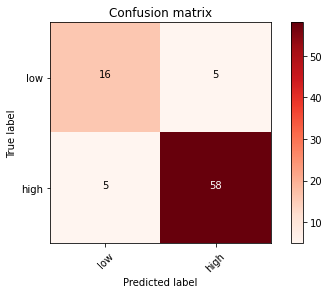

In [30]:
from OpenFabLibrary import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels_val, predicted_labels)
cm_plot_labels = ['low', 'high'] #['low', 'medium', 'high']
plot_confusion_matrix(cm, cm_plot_labels)

## Save the model to DRIVE

In [ ]:
# !tar -czf BERTmodel.tar.gz model
# !mv BERTmodel.tar.gz ../drive/My\ Drive/Colab\ data/BERT/ 

## Test the model

In [32]:
#multiple inputs
#用記事本打開csv文件，另存為设置編碼為utf-8
test_data_source = "data/test_data_0817.csv"
test_data_df = pd.read_csv(test_data_source, encoding='utf8', delimiter=',')
print(test_data_df.head())

   ID                                        Description  Class
0   0  - - - - - - - - - - - - - -附錄：【發文與推文罰則】- - - -...    NaN
1   1                     --　　　　　　　　　　　　　　　　　　　　　    　--    NaN
2   2  版友們有哪些討厭的副作用呢？今天去運動途中哭了因為副作用讓我覺得沒辦法掌控自己的身體很痛苦 ...    NaN
3   3  「我會在，你放心。我們就慢慢把環境適應。」治療的最後，L說著，想要安撫我下週工作室搬遷的焦慮...    NaN
4   4  其實我也不知道在焦慮甚麼也許是不想有人來管吧?本來是社區自聘的管理員6/1起外包給保全公司我...    NaN


In [50]:
test_data = list(test_data_df['Description'])
print(test_data[0])

##################################################
- - - - - - - - - - - - - -附錄：【發文與推文罰則】- - - - - - - - - - - - - -第一條　凡未分類、自創分類、未滿20字（不含標點符號）之文章，　　　　含有自殺、自殘、OD相關內容，未在標題加註「有雷」或「雷」者，　　　　初犯者板主將直接刪除文章，不另外公告或通知。　　　　其後發文或推文仍未改善者劣退水桶一個月。三犯永久水桶。第二條　發文內容或推文大部分內容，違反中華民國法律者，　　　　初犯者板主將直接刪除文章並並水桶三日，不另外公告或通知。　　　　其後發文或推文仍未改善者劣退水桶一個月。三犯永久水桶。第三條　尋死文、自殺文、自殘文、OD文、藥物徵求買賣文等違規文章，　　　　除自殺文暫保留二日以便板友關心追蹤外，其餘文直接刪除並水桶三日。　　　　解除水桶之後其發文仍未遵循板規者，其發文劣退並水桶一個月。　　　　水桶後無論自行發文或在其他板友文章內推文再犯者皆永久水桶。第四條　本板對人身攻擊定義，不論是主動攻擊他人或因對他人言論不滿而回擊者，　　　　只要構成人身攻擊之事實，即視為違規，依程度輕重照板規懲處。　　　　此外，意見不合與人身攻擊間有很大的落差，　　　　請發文推文者勿因他人持反對意見，就任意指責對方人身攻擊，　　　　如經板主認定檢舉人有濫訴之嫌，得以不回應其檢舉。　　　　　　　認定標準為：該字詞足以引起本板板友普遍性之不悅，並達到動怒的程度。　　　　例：「你根本不是憂鬱症吧！」、「會生病是你活該」等　　　　普通人身攻擊文劣退處理，並水桶一週；於推文中普通人身攻擊者水桶一週。　　　　其後發文或推文仍未改善者劣退水桶一個月。三犯永久水桶。　　　　　　　認定標準為：該字詞足以引起一般使用者普遍性之不悅，並達到動怒的程度。　　　　例：「你去死」、「吃屎吧你」等　　　　惡意人身攻擊文劣退處理，並水桶二週；於推文中惡意人身攻擊者水桶二週。　　　　其後發文或推文仍未改善者劣退水桶二個月。三犯永久水桶。　　　　　　　認定標準為：可能觸犯刑法公然侮辱罪，含三字經、不雅形容詞等用詞。　　　　例：「幹」、「醜」、「賤」、「智障」、「白痴」、「腦殘」、「丁丁」等。　　　　公然侮辱罪需針對特定人士辱罵才能成立，用以上詞彙評論事件，　　　

In [51]:
test_results = getPrediction(test_data)
print("#"*50)
print(test_results[0])

INFO:tensorflow:Writing example 0 of 200


INFO:tensorflow:Writing example 0 of 200


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] - - - - - - - - - - - - - - 附 錄 ： 【 發 文 與 推 文 罰 則 】 - - - - - - - - - - - - - - 第 一 條 凡 未 分 類 、 自 創 分 類 、 未 滿 20 字 （ 不 含 標 點 符 號 ） 之 文 章 ， 含 有 自 殺 、 自 殘 、 [UNK] 相 關 內 容 ， 未 在 標 題 加 註 「 有 雷 」 或 「 雷 」 者 ， 初 犯 者 板 主 將 直 接 刪 除 文 章 ， 不 另 外 公 告 或 通 知 。 其 後 發 文 或 推 文 仍 未 改 善 者 劣 退 水 桶 一 個 月 。 三 犯 永 久 水 桶 。 第 二 條 發 文 內 容 或 推 文 大 部 分 內 容 ， 違 反 中 華 民 國 法 律 者 ， 初 犯 者 板 主 將 直 接 刪 除 文 章 並 並 水 桶 三 日 ， 不 另 外 公 告 或 通 知 。 其 後 發 文 或 推 文 仍 未 改 善 者 劣 退 水 桶 一 個 月 。 三 犯 永 久 水 桶 。 第 三 條 尋 死 文 、 自 殺 文 、 自 殘 文 、 [UNK] 文 、 藥 物 徵 求 買 賣 文 [SEP]


INFO:tensorflow:tokens: [CLS] - - - - - - - - - - - - - - 附 錄 ： 【 發 文 與 推 文 罰 則 】 - - - - - - - - - - - - - - 第 一 條 凡 未 分 類 、 自 創 分 類 、 未 滿 20 字 （ 不 含 標 點 符 號 ） 之 文 章 ， 含 有 自 殺 、 自 殘 、 [UNK] 相 關 內 容 ， 未 在 標 題 加 註 「 有 雷 」 或 「 雷 」 者 ， 初 犯 者 板 主 將 直 接 刪 除 文 章 ， 不 另 外 公 告 或 通 知 。 其 後 發 文 或 推 文 仍 未 改 善 者 劣 退 水 桶 一 個 月 。 三 犯 永 久 水 桶 。 第 二 條 發 文 內 容 或 推 文 大 部 分 內 容 ， 違 反 中 華 民 國 法 律 者 ， 初 犯 者 板 主 將 直 接 刪 除 文 章 並 並 水 桶 三 日 ， 不 另 外 公 告 或 通 知 。 其 後 發 文 或 推 文 仍 未 改 善 者 劣 退 水 桶 一 個 月 。 三 犯 永 久 水 桶 。 第 三 條 尋 死 文 、 自 殺 文 、 自 殘 文 、 [UNK] 文 、 藥 物 徵 求 買 賣 文 [SEP]


INFO:tensorflow:input_ids: 101 118 118 118 118 118 118 118 118 118 118 118 118 118 118 7353 7087 8038 523 4634 3152 5645 2972 3152 5391 1179 524 118 118 118 118 118 118 118 118 118 118 118 118 118 118 5018 671 3454 1127 3313 1146 7546 510 5632 1201 1146 7546 510 3313 4021 8113 2099 8020 679 1419 3560 7953 5016 5998 8021 722 3152 4995 8024 1419 3300 5632 3669 510 5632 3659 510 100 4685 7302 1058 2159 8024 3313 1762 3560 7539 1217 6263 519 3300 7440 520 2772 519 7440 520 5442 8024 1159 4306 5442 3352 712 2200 4684 2970 1165 7370 3152 4995 8024 679 1369 1912 1062 1440 2772 6858 4761 511 1071 2527 4634 3152 2772 2972 3152 793 3313 3121 1587 5442 1219 6842 3717 3446 671 943 3299 511 676 4306 3719 719 3717 3446 511 5018 753 3454 4634 3152 1058 2159 2772 2972 3152 1920 6956 1146 1058 2159 8024 6889 1353 704 5836 3696 1751 3791 2526 5442 8024 1159 4306 5442 3352 712 2200 4684 2970 1165 7370 3152 4995 699 699 3717 3446 676 3189 8024 679 1369 1912 1062 1440 2772 6858 4761 511 1071 2527 4634 3152

INFO:tensorflow:input_ids: 101 118 118 118 118 118 118 118 118 118 118 118 118 118 118 7353 7087 8038 523 4634 3152 5645 2972 3152 5391 1179 524 118 118 118 118 118 118 118 118 118 118 118 118 118 118 5018 671 3454 1127 3313 1146 7546 510 5632 1201 1146 7546 510 3313 4021 8113 2099 8020 679 1419 3560 7953 5016 5998 8021 722 3152 4995 8024 1419 3300 5632 3669 510 5632 3659 510 100 4685 7302 1058 2159 8024 3313 1762 3560 7539 1217 6263 519 3300 7440 520 2772 519 7440 520 5442 8024 1159 4306 5442 3352 712 2200 4684 2970 1165 7370 3152 4995 8024 679 1369 1912 1062 1440 2772 6858 4761 511 1071 2527 4634 3152 2772 2972 3152 793 3313 3121 1587 5442 1219 6842 3717 3446 671 943 3299 511 676 4306 3719 719 3717 3446 511 5018 753 3454 4634 3152 1058 2159 2772 2972 3152 1920 6956 1146 1058 2159 8024 6889 1353 704 5836 3696 1751 3791 2526 5442 8024 1159 4306 5442 3352 712 2200 4684 2970 1165 7370 3152 4995 699 699 3717 3446 676 3189 8024 679 1369 1912 1062 1440 2772 6858 4761 511 1071 2527 4634 3152

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] - - - - [SEP]


INFO:tensorflow:tokens: [CLS] - - - - [SEP]


INFO:tensorflow:input_ids: 101 118 118 118 118 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 118 118 118 118 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 版 友 們 有 哪 些 討 厭 的 副 作 用 呢 ？ 今 天 去 運 動 途 中 哭 了 因 為 副 作 用 讓 我 覺 得 沒 辦 法 掌 控 自 己 的 身 體 很 痛 苦 悲 從 中 來 運 動 暫 時 可 以 忘 掉 但 一 想 到 眼 淚 就 冒 出 眼 眶 好 痛 苦 但 不 能 不 吃 藥 希 望 自 己 不 要 被 藥 物 綁 住 但 現 階 段 我 不 能 不 吃 藥 . . . 好 沮 喪 感 覺 連 掌 控 權 都 沒 有 「 妳 還 好 嗎 ？ 」 人 們 問 。 「 我 不 好 。 」 她 們 就 會 一 臉 尷 尬 的 沈 默 了 不 然 你 們 希 冀 什 麼 答 案 啊 ？ - - + 1 可 以 問 但 是 不 要 對 方 回 答 負 面 的 就 不 開 心 的 沈 默 . . . [UNK] 或 是 無 語 問 蒼 天 嗯 嗯 不 要 期 待 一 個 很 正 面 的 回 答 不 要 去 預 設 一 個 美 好 的 回 應 [SEP]


INFO:tensorflow:tokens: [CLS] 版 友 們 有 哪 些 討 厭 的 副 作 用 呢 ？ 今 天 去 運 動 途 中 哭 了 因 為 副 作 用 讓 我 覺 得 沒 辦 法 掌 控 自 己 的 身 體 很 痛 苦 悲 從 中 來 運 動 暫 時 可 以 忘 掉 但 一 想 到 眼 淚 就 冒 出 眼 眶 好 痛 苦 但 不 能 不 吃 藥 希 望 自 己 不 要 被 藥 物 綁 住 但 現 階 段 我 不 能 不 吃 藥 . . . 好 沮 喪 感 覺 連 掌 控 權 都 沒 有 「 妳 還 好 嗎 ？ 」 人 們 問 。 「 我 不 好 。 」 她 們 就 會 一 臉 尷 尬 的 沈 默 了 不 然 你 們 希 冀 什 麼 答 案 啊 ？ - - + 1 可 以 問 但 是 不 要 對 方 回 答 負 面 的 就 不 開 心 的 沈 默 . . . [UNK] 或 是 無 語 問 蒼 天 嗯 嗯 不 要 期 待 一 個 很 正 面 的 回 答 不 要 去 預 設 一 個 美 好 的 回 應 [SEP]


INFO:tensorflow:input_ids: 101 4276 1351 947 3300 1525 763 6245 1339 4638 1199 868 4500 1450 8043 791 1921 1343 6880 1240 6854 704 1526 749 1728 4158 1199 868 4500 6366 2769 6221 2533 3760 6794 3791 2958 2971 5632 2346 4638 6716 7768 2523 4578 5736 2650 2537 704 889 6880 1240 3271 3229 1377 809 2563 2957 852 671 2682 1168 4706 3907 2218 1088 1139 4706 4702 1962 4578 5736 852 679 5543 679 1391 5973 2361 3307 5632 2346 679 6206 6158 5973 4289 5192 857 852 4412 7389 3667 2769 679 5543 679 1391 5973 119 119 119 1962 3775 1603 2697 6221 6865 2958 2971 3609 6963 3760 3300 519 1986 6917 1962 1621 8043 520 782 947 1558 511 519 2769 679 1962 511 520 1961 947 2218 3298 671 5622 2220 2217 4638 3755 7949 749 679 4197 872 947 2361 1078 784 7938 5031 3428 1557 8043 118 118 116 122 1377 809 1558 852 3221 679 6206 2205 3175 1726 5031 6511 7481 4638 2218 679 7274 2552 4638 3755 7949 119 119 119 100 2772 3221 4192 6295 1558 5895 1921 1638 1638 679 6206 3309 2521 671 943 2523 3633 7481 4638 1726 5031 679

INFO:tensorflow:input_ids: 101 4276 1351 947 3300 1525 763 6245 1339 4638 1199 868 4500 1450 8043 791 1921 1343 6880 1240 6854 704 1526 749 1728 4158 1199 868 4500 6366 2769 6221 2533 3760 6794 3791 2958 2971 5632 2346 4638 6716 7768 2523 4578 5736 2650 2537 704 889 6880 1240 3271 3229 1377 809 2563 2957 852 671 2682 1168 4706 3907 2218 1088 1139 4706 4702 1962 4578 5736 852 679 5543 679 1391 5973 2361 3307 5632 2346 679 6206 6158 5973 4289 5192 857 852 4412 7389 3667 2769 679 5543 679 1391 5973 119 119 119 1962 3775 1603 2697 6221 6865 2958 2971 3609 6963 3760 3300 519 1986 6917 1962 1621 8043 520 782 947 1558 511 519 2769 679 1962 511 520 1961 947 2218 3298 671 5622 2220 2217 4638 3755 7949 749 679 4197 872 947 2361 1078 784 7938 5031 3428 1557 8043 118 118 116 122 1377 809 1558 852 3221 679 6206 2205 3175 1726 5031 6511 7481 4638 2218 679 7274 2552 4638 3755 7949 119 119 119 100 2772 3221 4192 6295 1558 5895 1921 1638 1638 679 6206 3309 2521 671 943 2523 3633 7481 4638 1726 5031 679

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 「 我 會 在 ， 你 放 心 。 我 們 就 慢 慢 把 環 境 適 應 。 」 治 療 的 最 後 ， [UNK] 說 著 ， 想 要 安 撫 我 下 週 工 作 室 搬 遷 的 焦 慮 。 當 下 覺 得 很 溫 暖 ， 很 放 心 地 微 笑 了 ， 可 是 我 現 在 卻 快 要 被 恐 懼 焦 慮 淹 沒 ， 因 為 [UNK] 也 給 過 我 太 多 承 諾 。 我 很 清 楚 [UNK] 和 [UNK] 是 截 然 不 同 的 ， [UNK] 是 會 員 是 候 選 人 ， 這 就 是 他 的 工 作 ， 所 以 他 會 在 。 這 些 我 都 知 道 ， 我 也 以 為 我 已 經 100 % 依 賴 [UNK] ， 是 可 以 懂 他 只 是 為 了 讓 我 安 心 ， 告 訴 我 他 會 在 新 的 工 作 室 等 著 我 過 去 。 可 是 我 現 在 焦 慮 到 想 吐 [UNK] 既 昨 天 腰 痛 之 後 今 天 多 了 背 痛 ， 一 定 又 是 重 訓 的 過 程 中 姿 勢 錯 誤 導 致 的 ， 但 重 點 是 我 不 知 道 問 題 在 哪 裡 > < 和 現 在 的 教 練 上 課 已 經 超 過 半 年 ， 然 而 [SEP]


INFO:tensorflow:tokens: [CLS] 「 我 會 在 ， 你 放 心 。 我 們 就 慢 慢 把 環 境 適 應 。 」 治 療 的 最 後 ， [UNK] 說 著 ， 想 要 安 撫 我 下 週 工 作 室 搬 遷 的 焦 慮 。 當 下 覺 得 很 溫 暖 ， 很 放 心 地 微 笑 了 ， 可 是 我 現 在 卻 快 要 被 恐 懼 焦 慮 淹 沒 ， 因 為 [UNK] 也 給 過 我 太 多 承 諾 。 我 很 清 楚 [UNK] 和 [UNK] 是 截 然 不 同 的 ， [UNK] 是 會 員 是 候 選 人 ， 這 就 是 他 的 工 作 ， 所 以 他 會 在 。 這 些 我 都 知 道 ， 我 也 以 為 我 已 經 100 % 依 賴 [UNK] ， 是 可 以 懂 他 只 是 為 了 讓 我 安 心 ， 告 訴 我 他 會 在 新 的 工 作 室 等 著 我 過 去 。 可 是 我 現 在 焦 慮 到 想 吐 [UNK] 既 昨 天 腰 痛 之 後 今 天 多 了 背 痛 ， 一 定 又 是 重 訓 的 過 程 中 姿 勢 錯 誤 導 致 的 ， 但 重 點 是 我 不 知 道 問 題 在 哪 裡 > < 和 現 在 的 教 練 上 課 已 經 超 過 半 年 ， 然 而 [SEP]


INFO:tensorflow:input_ids: 101 519 2769 3298 1762 8024 872 3123 2552 511 2769 947 2218 2714 2714 2828 4472 1862 6900 2746 511 520 3780 4615 4638 3297 2527 8024 100 6303 5865 8024 2682 6206 2128 3062 2769 678 6867 2339 868 2147 3021 6907 4638 4193 2719 511 4534 678 6221 2533 2523 3984 3265 8024 2523 3123 2552 1765 2544 5010 749 8024 1377 3221 2769 4412 1762 1320 2571 6206 6158 2607 2758 4193 2719 3922 3760 8024 1728 4158 100 738 5183 6882 2769 1922 1914 2824 6330 511 2769 2523 3926 3504 100 1469 100 3221 2779 4197 679 1398 4638 8024 100 3221 3298 1519 3221 952 6908 782 8024 6857 2218 3221 800 4638 2339 868 8024 2792 809 800 3298 1762 511 6857 763 2769 6963 4761 6887 8024 2769 738 809 4158 2769 2347 5195 8135 110 898 6552 100 8024 3221 1377 809 2743 800 1372 3221 4158 749 6366 2769 2128 2552 8024 1440 6260 2769 800 3298 1762 3173 4638 2339 868 2147 5023 5865 2769 6882 1343 511 1377 3221 2769 4412 1762 4193 2719 1168 2682 1402 100 3188 3219 1921 5587 4578 722 2527 791 1921 1914 749 5520 4

INFO:tensorflow:input_ids: 101 519 2769 3298 1762 8024 872 3123 2552 511 2769 947 2218 2714 2714 2828 4472 1862 6900 2746 511 520 3780 4615 4638 3297 2527 8024 100 6303 5865 8024 2682 6206 2128 3062 2769 678 6867 2339 868 2147 3021 6907 4638 4193 2719 511 4534 678 6221 2533 2523 3984 3265 8024 2523 3123 2552 1765 2544 5010 749 8024 1377 3221 2769 4412 1762 1320 2571 6206 6158 2607 2758 4193 2719 3922 3760 8024 1728 4158 100 738 5183 6882 2769 1922 1914 2824 6330 511 2769 2523 3926 3504 100 1469 100 3221 2779 4197 679 1398 4638 8024 100 3221 3298 1519 3221 952 6908 782 8024 6857 2218 3221 800 4638 2339 868 8024 2792 809 800 3298 1762 511 6857 763 2769 6963 4761 6887 8024 2769 738 809 4158 2769 2347 5195 8135 110 898 6552 100 8024 3221 1377 809 2743 800 1372 3221 4158 749 6366 2769 2128 2552 8024 1440 6260 2769 800 3298 1762 3173 4638 2339 868 2147 5023 5865 2769 6882 1343 511 1377 3221 2769 4412 1762 4193 2719 1168 2682 1402 100 3188 3219 1921 5587 4578 722 2527 791 1921 1914 749 5520 4

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 其 實 我 也 不 知 道 在 焦 慮 甚 麼 也 許 是 不 想 有 人 來 管 吧 ? 本 來 是 社 區 自 聘 的 管 理 員 6 / 1 起 外 包 給 保 全 公 司 我 也 確 定 留 任 了 可 是 從 得 知 消 息 之 後 還 是 一 樣 焦 慮 今 天 去 保 全 公 司 面 談 ， 填 了 一 堆 不 知 道 是 甚 麼 的 資 料 （ 這 點 很 危 險 ， 好 孩 子 不 要 學 ） 因 為 還 有 另 一 個 同 事 不 知 為 何 早 到 ， 保 全 公 司 的 說 要 一 起 解 釋 ， 所 以 我 不 好 意 思 讓 他 等 其 實 事 後 也 沒 有 甚 麼 解 釋 ， 很 多 事 沒 搞 清 楚 其 實 就 制 度 面 來 說 ， 有 公 司 會 比 較 好 至 少 以 後 勞 健 保 有 著 落 了 以 後 上 班 時 間 相 對 固 定 ， 輪 班 不 像 現 在 這 樣 常 常 日 夜 顛 倒 而 且 工 作 地 點 沒 變 ， 服 務 對 象 沒 變 但 一 想 到 上 面 突 然 多 了 陌 生 人 來 管 就 覺 得 莫 名 害 怕 上 次 這 樣 [SEP]


INFO:tensorflow:tokens: [CLS] 其 實 我 也 不 知 道 在 焦 慮 甚 麼 也 許 是 不 想 有 人 來 管 吧 ? 本 來 是 社 區 自 聘 的 管 理 員 6 / 1 起 外 包 給 保 全 公 司 我 也 確 定 留 任 了 可 是 從 得 知 消 息 之 後 還 是 一 樣 焦 慮 今 天 去 保 全 公 司 面 談 ， 填 了 一 堆 不 知 道 是 甚 麼 的 資 料 （ 這 點 很 危 險 ， 好 孩 子 不 要 學 ） 因 為 還 有 另 一 個 同 事 不 知 為 何 早 到 ， 保 全 公 司 的 說 要 一 起 解 釋 ， 所 以 我 不 好 意 思 讓 他 等 其 實 事 後 也 沒 有 甚 麼 解 釋 ， 很 多 事 沒 搞 清 楚 其 實 就 制 度 面 來 說 ， 有 公 司 會 比 較 好 至 少 以 後 勞 健 保 有 著 落 了 以 後 上 班 時 間 相 對 固 定 ， 輪 班 不 像 現 在 這 樣 常 常 日 夜 顛 倒 而 且 工 作 地 點 沒 變 ， 服 務 對 象 沒 變 但 一 想 到 上 面 突 然 多 了 陌 生 人 來 管 就 覺 得 莫 名 害 怕 上 次 這 樣 [SEP]


INFO:tensorflow:input_ids: 101 1071 2179 2769 738 679 4761 6887 1762 4193 2719 4493 7938 738 6258 3221 679 2682 3300 782 889 5052 1416 136 3315 889 3221 4852 1281 5632 5470 4638 5052 4415 1519 127 120 122 6629 1912 1259 5183 924 1059 1062 1385 2769 738 4825 2137 4522 818 749 1377 3221 2537 2533 4761 3867 2622 722 2527 6917 3221 671 3564 4193 2719 791 1921 1343 924 1059 1062 1385 7481 6312 8024 1856 749 671 1831 679 4761 6887 3221 4493 7938 4638 6536 3160 8020 6857 7953 2523 1314 7402 8024 1962 2111 2094 679 6206 2119 8021 1728 4158 6917 3300 1369 671 943 1398 752 679 4761 4158 862 3193 1168 8024 924 1059 1062 1385 4638 6303 6206 671 6629 6237 7026 8024 2792 809 2769 679 1962 2692 2590 6366 800 5023 1071 2179 752 2527 738 3760 3300 4493 7938 6237 7026 8024 2523 1914 752 3760 3018 3926 3504 1071 2179 2218 1169 2428 7481 889 6303 8024 3300 1062 1385 3298 3683 6733 1962 5635 2208 809 2527 1246 978 924 3300 5865 5862 749 809 2527 677 4408 3229 7279 4685 2205 1743 2137 8024 6743 4408 679 100

INFO:tensorflow:input_ids: 101 1071 2179 2769 738 679 4761 6887 1762 4193 2719 4493 7938 738 6258 3221 679 2682 3300 782 889 5052 1416 136 3315 889 3221 4852 1281 5632 5470 4638 5052 4415 1519 127 120 122 6629 1912 1259 5183 924 1059 1062 1385 2769 738 4825 2137 4522 818 749 1377 3221 2537 2533 4761 3867 2622 722 2527 6917 3221 671 3564 4193 2719 791 1921 1343 924 1059 1062 1385 7481 6312 8024 1856 749 671 1831 679 4761 6887 3221 4493 7938 4638 6536 3160 8020 6857 7953 2523 1314 7402 8024 1962 2111 2094 679 6206 2119 8021 1728 4158 6917 3300 1369 671 943 1398 752 679 4761 4158 862 3193 1168 8024 924 1059 1062 1385 4638 6303 6206 671 6629 6237 7026 8024 2792 809 2769 679 1962 2692 2590 6366 800 5023 1071 2179 752 2527 738 3760 3300 4493 7938 6237 7026 8024 2523 1914 752 3760 3018 3926 3504 1071 2179 2218 1169 2428 7481 889 6303 8024 3300 1062 1385 3298 3683 6733 1962 5635 2208 809 2527 1246 978 924 3300 5865 5862 749 809 2527 677 4408 3229 7279 4685 2205 1743 2137 8024 6743 4408 679 100

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model/model.ckpt-70


INFO:tensorflow:Restoring parameters from model/model.ckpt-70


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


##################################################
('- - - - - - - - - - - - - -附錄：【發文與推文罰則】- - - - - - - - - - - - - -第一條\u3000凡未分類、自創分類、未滿20字（不含標點符號）之文章，\u3000\u3000\u3000\u3000含有自殺、自殘、OD相關內容，未在標題加註「有雷」或「雷」者，\u3000\u3000\u3000\u3000初犯者板主將直接刪除文章，不另外公告或通知。\u3000\u3000\u3000\u3000其後發文或推文仍未改善者劣退水桶一個月。三犯永久水桶。第二條\u3000發文內容或推文大部分內容，違反中華民國法律者，\u3000\u3000\u3000\u3000初犯者板主將直接刪除文章並並水桶三日，不另外公告或通知。\u3000\u3000\u3000\u3000其後發文或推文仍未改善者劣退水桶一個月。三犯永久水桶。第三條\u3000尋死文、自殺文、自殘文、OD文、藥物徵求買賣文等違規文章，\u3000\u3000\u3000\u3000除自殺文暫保留二日以便板友關心追蹤外，其餘文直接刪除並水桶三日。\u3000\u3000\u3000\u3000解除水桶之後其發文仍未遵循板規者，其發文劣退並水桶一個月。\u3000\u3000\u3000\u3000水桶後無論自行發文或在其他板友文章內推文再犯者皆永久水桶。第四條\u3000本板對人身攻擊定義，不論是主動攻擊他人或因對他人言論不滿而回擊者，\u3000\u3000\u3000\u3000只要構成人身攻擊之事實，即視為違規，依程度輕重照板規懲處。\u3000\u3000\u3000\u3000此外，意見不合與人身攻擊間有很大的落差，\u3000\u3000\u3000\u3000請發文推文者勿因他人持反對意見，就任意指責對方人身攻擊，\u3000\u3000\u3000\u3000如經板主認定檢舉人有濫訴之嫌，得以不回應其檢舉。\u3000\u3000\u3000\u3000\u3000\u3000\u3000認定標準為：該字詞足以引起本板板友普遍性之不悅，並達到動怒的程度。\u3000\u3000\u3000\u3000例：「你根本不是憂鬱症吧！」、「會生病是

In [53]:
results = [tr[2] for tr in test_results]
print(results)

[0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1]


In [54]:
test_data_df['Predicted'] = results
test_data_df.to_csv('data/suicide_test_result.csv', encoding='utf8')

## Free test here

In [ ]:
#Classifying random sentences
test_results = getPrediction(['其實我本來就不太想活了每次和媽媽說完話我就開始辜狗自殺方法',
                       '帶了很多藥來就是因為怕這樣的時刻又出現這才是真正的逢魔時刻吧想自我毀滅盡量躺著保持安靜再撐幾天就回家了沒事的',
                       '還有半小時覺得倦怠低落負面而自我放逐下班要吃冰冰彷彿是每天的救贖潰瘍還沒好',
                       '群組裡面都是很負面的話受不了就不要加入下輩子再見也可以說不定會好 '
                       ])

INFO:tensorflow:Writing example 0 of 4


INFO:tensorflow:Writing example 0 of 4


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 其 實 我 本 來 就 不 太 想 活 了 每 次 和 媽 媽 說 完 話 我 就 開 始 辜 狗 自 殺 方 法 [SEP]


INFO:tensorflow:tokens: [CLS] 其 實 我 本 來 就 不 太 想 活 了 每 次 和 媽 媽 說 完 話 我 就 開 始 辜 狗 自 殺 方 法 [SEP]


INFO:tensorflow:input_ids: 101 1071 2179 2769 3315 889 2218 679 1922 2682 3833 749 3680 3613 1469 2061 2061 6303 2130 6282 2769 2218 7274 1993 6790 4318 5632 3669 3175 3791 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1071 2179 2769 3315 889 2218 679 1922 2682 3833 749 3680 3613 1469 2061 2061 6303 2130 6282 2769 2218 7274 1993 6790 4318 5632 3669 3175 3791 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 帶 了 很 多 藥 來 就 是 因 為 怕 這 樣 的 時 刻 又 出 現 這 才 是 真 正 的 逢 魔 時 刻 吧 想 自 我 毀 滅 盡 量 躺 著 保 持 安 靜 再 撐 幾 天 就 回 家 了 沒 事 的 [SEP]


INFO:tensorflow:tokens: [CLS] 帶 了 很 多 藥 來 就 是 因 為 怕 這 樣 的 時 刻 又 出 現 這 才 是 真 正 的 逢 魔 時 刻 吧 想 自 我 毀 滅 盡 量 躺 著 保 持 安 靜 再 撐 幾 天 就 回 家 了 沒 事 的 [SEP]


INFO:tensorflow:input_ids: 101 2380 749 2523 1914 5973 889 2218 3221 1728 4158 2586 6857 3564 4638 3229 1174 1348 1139 4412 6857 2798 3221 4696 3633 4638 6864 7795 3229 1174 1416 2682 5632 2769 3672 3994 4674 7030 6720 5865 924 2898 2128 7477 1086 3052 2407 1921 2218 1726 2157 749 3760 752 4638 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2380 749 2523 1914 5973 889 2218 3221 1728 4158 2586 6857 3564 4638 3229 1174 1348 1139 4412 6857 2798 3221 4696 3633 4638 6864 7795 3229 1174 1416 2682 5632 2769 3672 3994 4674 7030 6720 5865 924 2898 2128 7477 1086 3052 2407 1921 2218 1726 2157 749 3760 752 4638 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 還 有 半 小 時 覺 得 倦 怠 低 落 負 面 而 自 我 放 逐 下 班 要 吃 冰 冰 彷 彿 是 每 天 的 救 贖 潰 瘍 還 沒 好 [SEP]


INFO:tensorflow:tokens: [CLS] 還 有 半 小 時 覺 得 倦 怠 低 落 負 面 而 自 我 放 逐 下 班 要 吃 冰 冰 彷 彿 是 每 天 的 救 贖 潰 瘍 還 沒 好 [SEP]


INFO:tensorflow:input_ids: 101 6917 3300 1288 2207 3229 6221 2533 958 2591 856 5862 6511 7481 5445 5632 2769 3123 6852 678 4408 6206 1391 1102 1102 2513 2517 3221 3680 1921 4638 3131 6562 4061 4598 6917 3760 1962 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 6917 3300 1288 2207 3229 6221 2533 958 2591 856 5862 6511 7481 5445 5632 2769 3123 6852 678 4408 6206 1391 1102 1102 2513 2517 3221 3680 1921 4638 3131 6562 4061 4598 6917 3760 1962 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 群 組 裡 面 都 是 很 負 面 的 話 受 不 了 就 不 要 加 入 下 輩 子 再 見 也 可 以 說 不 定 會 好 [SEP]


INFO:tensorflow:tokens: [CLS] 群 組 裡 面 都 是 很 負 面 的 話 受 不 了 就 不 要 加 入 下 輩 子 再 見 也 可 以 說 不 定 會 好 [SEP]


INFO:tensorflow:input_ids: 101 5408 5175 6174 7481 6963 3221 2523 6511 7481 4638 6282 1358 679 749 2218 679 6206 1217 1057 678 6742 2094 1086 6210 738 1377 809 6303 679 2137 3298 1962 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 5408 5175 6174 7481 6963 3221 2523 6511 7481 4638 6282 1358 679 749 2218 679 6206 1217 1057 678 6742 2094 1086 6210 738 1377 809 6303 679 2137 3298 1962 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model/model.ckpt-80


INFO:tensorflow:Restoring parameters from model/model.ckpt-80


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [ ]:
test_results

[('其實我本來就不太想活了每次和媽媽說完話我就開始辜狗自殺方法',
  array([-2.455091  , -1.3244265 , -0.43357265], dtype=float32),
  2,
  'high'),
 ('帶了很多藥來就是因為怕這樣的時刻又出現這才是真正的逢魔時刻吧想自我毀滅盡量躺著保持安靜再撐幾天就回家了沒事的',
  array([-1.324    , -0.7256511, -1.3866073], dtype=float32),
  1,
  'medium'),
 ('還有半小時覺得倦怠低落負面而自我放逐下班要吃冰冰彷彿是每天的救贖潰瘍還沒好',
  array([-1.1450806, -0.6767058, -1.7515025], dtype=float32),
  1,
  'medium'),
 ('群組裡面都是很負面的話受不了就不要加入下輩子再見也可以說不定會好 ',
  array([-0.08778379, -2.7265542 , -3.9847727 ], dtype=float32),
  0,
  'low')]

Reference: https://analyticsindiamag.com/step-by-step-guide-to-implement-multi-class-classification-with-bert-tensorflow/